# AdEase Case Study

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import duckdb as db
import random
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pl.Config(fmt_str_lengths=100)
import seaborn as sns
sns.set_theme(style="whitegrid")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape

)
from datetime import timedelta
import optuna
from prophet import Prophet

import warnings

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.tsa.base.tsa_model")
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="statsmodels.base.model")

Importing plotly failed. Interactive plots will not work.


In [16]:
columns = ['Spanish', 'Japanese', 'English', 'Chinese', 'German', 'Russian', 'French']

# Data Loading

In [168]:
df = pl.read_csv("../data/raw/train_1.csv", has_header=True, ignore_errors=True)
lang_df = pl.read_csv("../data/processed/langcodes.csv", has_header=True, ignore_errors=True)

In [82]:
df

shape: (145_063, 551)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Page      ┆ 2015-07-0 ┆ 2015-07-0 ┆ 2015-07-0 ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12- │
│ ---       ┆ 1         ┆ 2         ┆ 3         ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 31       │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ i64       ┆ i64       ┆ i64       ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2NE1_zh.w ┆ 18        ┆ 11        ┆ 5         ┆ … ┆ 22        ┆ 19        ┆ 18        ┆ 20       │
│ ikipedia. ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ org_all-a ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ccess_spi ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ der       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2PM_zh.wi ┆ 11        ┆ 14        ┆ 15        ┆ … ┆ 52        ┆ 45        ┆ 26        ┆ 20       │
│ kipedia.o ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ rg_all-ac ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ cess_spid ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ er        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3C_zh.wik ┆ 1         ┆ 0         ┆ 1         ┆ … ┆ 6         ┆ 3         ┆ 4         ┆ 17       │
│ ipedia.or ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ g_all-acc ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ess_spide ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ r         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 4minute_z ┆ 35        ┆ 13        ┆ 10        ┆ … ┆ 17        ┆ 19        ┆ 10        ┆ 11       │
│ h.wikiped ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ia.org_al ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ l-access_ ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ spider    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 52_Hz_I_L ┆ null      ┆ null      ┆ null      ┆ … ┆ 27        ┆ 13        ┆ 36        ┆ 10       │
│ ove_You_z ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ h.wikiped ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ia.org_al ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ l-access_ ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ spider    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ Underworl ┆ null      ┆ null      ┆ null      ┆ … ┆ 13        ┆ 3         ┆ 5         ┆ 10       │
│ d_(serie_ ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ de_pelícu ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ las)_es.w ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ikipedia. ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ org_all-a ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ccess_spi ┆           ┆           ┆  

In [83]:
df.describe()

shape: (9, 552)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ Page      ┆ 2015-07-0 ┆ 2015-07-0 ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12- │
│ ---       ┆ ---       ┆ 1         ┆ 2         ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 31       │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 145063    ┆ 124323.0  ┆ 124247.0  ┆ … ┆ 141241.0  ┆ 141237.0  ┆ 141428.0  ┆ 141598.0 │
│ null_coun ┆ 0         ┆ 20740.0   ┆ 20816.0   ┆ … ┆ 3822.0    ┆ 3826.0    ┆ 3635.0    ┆ 3465.0   │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ 1195.8565 ┆ 1204.0036 ┆ … ┆ 1633.9656 ┆ 1684.3077 ┆ 1467.9433 ┆ 1478.282 │
│           ┆           ┆ 67        ┆ 38        ┆   ┆ 05        ┆ 17        ┆ 78        ┆ 137      │
│ std       ┆ null      ┆ 72753.518 ┆ 74215.145 ┆ … ┆ 91858.307 ┆ 90142.656 ┆ 81554.814 ┆ 88735.67 │
│           ┆           ┆ 671       ┆ 424       ┆   ┆ 668       ┆ 814       ┆ 146       ┆ 2589     │
│ min       ┆ !vote_en. ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│           ┆ wikipedia ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ .org_all- ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ access_al ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ l-agents  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ null      ┆ 13.0      ┆ 13.0      ┆ … ┆ 24.0      ┆ 23.0      ┆ 23.0      ┆ 21.0     │
│ 50%       ┆ null      ┆ 109.0     ┆ 108.0     ┆ … ┆ 163.0     ┆ 160.0     ┆ 154.0     ┆ 136.0    │
│ 75%       ┆ null      ┆ 524.0     ┆ 519.0     ┆ … ┆ 654.0     ┆ 649.0     ┆ 635.0     ┆ 561.0    │
│ max       ┆ ［Alexand ┆ 2.0381245 ┆ 2.0752194 ┆ … ┆ 2.7025053 ┆ 2.6073819 ┆ 2.4363967 ┆ 2.614954 │
│           ┆ ros］_ja. ┆ e7        ┆ e7        ┆   ┆ e7        ┆ e7        ┆ e7        ┆ 1e7      │
│           ┆ wikipedia ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ .org_mobi ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ le-web_al ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ l-agents  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [84]:
df=df.unique()

In [10]:
df.null_count().transpose(include_header=True)

shape: (551, 2)
┌────────────┬──────────┐
│ column     ┆ column_0 │
│ ---        ┆ ---      │
│ str        ┆ u32      │
╞════════════╪══════════╡
│ Page       ┆ 0        │
│ 2015-07-01 ┆ 20740    │
│ 2015-07-02 ┆ 20816    │
│ 2015-07-03 ┆ 20544    │
│ 2015-07-04 ┆ 20654    │
│ …          ┆ …        │
│ 2016-12-27 ┆ 3701     │
│ 2016-12-28 ┆ 3822     │
│ 2016-12-29 ┆ 3826     │
│ 2016-12-30 ┆ 3635     │
│ 2016-12-31 ┆ 3465     │
└────────────┴──────────┘

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that the dataset has lot of null values at the start and decreases at the end

# Data Cleaning

In [85]:
df=df.fill_nan(0)
df=df.fill_null(0)

In [10]:
df.select("Page").sample(10, seed=random.randint(0,1000))

shape: (10, 1)
┌──────────────────────────────────────────────────────────────────────────┐
│ Page                                                                     │
│ ---                                                                      │
│ str                                                                      │
╞══════════════════════════════════════════════════════════════════════════╡
│ Commons:Bureaucrats'_noticeboard_commons.wikimedia.org_all-access_spider │
│ J._Cole_en.wikipedia.org_all-access_spider                               │
│ Florian_Silbereisen_de.wikipedia.org_all-access_all-agents               │
│ 特命係長_只野仁_(テレビドラマ)_ja.wikipedia.org_desktop_all-agents       │
│ Ring_of_Fire_(song)_en.wikipedia.org_desktop_all-agents                  │
│ 青木珠菜_ja.wikipedia.org_desktop_all-agents                             │
│ Comunidad_es.wikipedia.org_all-access_spider                             │
│ 二二八事件受难者列表_zh.wikipedia.org_desktop_all-agents                 │
│ The_Originals_(TV_series)_en.wikipedia.org_desktop_all-agents            │
│ Special:MyLanguage/Help:Magic_words_www.mediawiki.org_all-access_spider  │
└──────────────────────────────────────────────────────────────────────────┘

In [23]:
db.sql("""
select Page from df where Page like '%_ja.%'
""").pl().sample(5)

shape: (5, 1)
┌───────────────────────────────────────────────────────────────┐
│ Page                                                          │
│ ---                                                           │
│ str                                                           │
╞═══════════════════════════════════════════════════════════════╡
│ ナチス・ドイツ_ja.wikipedia.org_all-access_spider             │
│ 森星_ja.wikipedia.org_desktop_all-agents                      │
│ 台風_ja.wikipedia.org_mobile-web_all-agents                   │
│ ヘリコバクター・ピロリ_ja.wikipedia.org_all-access_all-agents │
│ 豊田順子_ja.wikipedia.org_all-access_all-agents               │
└───────────────────────────────────────────────────────────────┘

In [86]:
# 'Manual:Installation_guide/en-gb_www.mediawiki.org_mobile-web_all-agents',
extracted_df = df.select(
    pl.col("Page").str.extract(r"/(\w{2})_www.mediawiki.org", group_index=1).alias("mediawiki_lang"),
    pl.col("Page").str.extract(r"_(\w{2})\.wikipedia", group_index=1).alias("wikipedia_lang"),
    pl.col("Page").str.extract(r"/(\w{2}-\w{2})_www.mediawiki.org", group_index=1).alias("separator_lang"),
)

In [87]:
extracted_df=extracted_df.with_columns(
    pl.concat_str([pl.col("mediawiki_lang"), pl.col("wikipedia_lang"), pl.col("separator_lang")], separator="", ignore_nulls=True).alias("lang")
)
extracted_df

shape: (145_063, 4)
┌────────────────┬────────────────┬────────────────┬──────┐
│ mediawiki_lang ┆ wikipedia_lang ┆ separator_lang ┆ lang │
│ ---            ┆ ---            ┆ ---            ┆ ---  │
│ str            ┆ str            ┆ str            ┆ str  │
╞════════════════╪════════════════╪════════════════╪══════╡
│ null           ┆ ja             ┆ null           ┆ ja   │
│ null           ┆ ru             ┆ null           ┆ ru   │
│ null           ┆ fr             ┆ null           ┆ fr   │
│ null           ┆ en             ┆ null           ┆ en   │
│ null           ┆ de             ┆ null           ┆ de   │
│ …              ┆ …              ┆ …              ┆ …    │
│ null           ┆ ru             ┆ null           ┆ ru   │
│ null           ┆ ru             ┆ null           ┆ ru   │
│ null           ┆ fr             ┆ null           ┆ fr   │
│ null           ┆ de             ┆ null           ┆ de   │
│ null           ┆ en             ┆ null           ┆ en   │
└────────────────┴────────────────┴────────────────┴──────┘

In [62]:
extracted_df.group_by("lang").len().sort("len", descending=True).limit(10)

shape: (10, 2)
┌───────┬───────┐
│ lang  ┆ len   │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ en    ┆ 24120 │
│ ja    ┆ 20515 │
│ de    ┆ 18692 │
│ fr    ┆ 17897 │
│ zh    ┆ 17330 │
│       ┆ 15775 │
│ ru    ┆ 15131 │
│ es    ┆ 14172 │
│ ar    ┆ 70    │
│ pt-br ┆ 66    │
└───────┴───────┘

In [88]:
df=df.with_columns(
    pl.col("Page").str.split("_").list[-1].alias("Agent"),
    pl.col("Page").str.split("_").list[-2].alias("Access"),
)

In [89]:
df = df.hstack(extracted_df.select("lang"))

In [90]:
df.select("Page", "lang").filter(pl.col("lang")=="").sample(10, seed=random.randint(0,1000))

shape: (10, 2)
┌───────────────────────────────────────────────────────────────────────────────────────────┬──────┐
│ Page                                                                                      ┆ lang │
│ ---                                                                                       ┆ ---  │
│ str                                                                                       ┆ str  │
╞═══════════════════════════════════════════════════════════════════════════════════════════╪══════╡
│ File:Bugatti_Veyron_16.4_–_Frontansicht,_5._April_2012,_Düsseldorf.jpg_commons.wikimedia. ┆      │
│ org_all-acc…                                                                              ┆      │
│ Manual:MIME_type_detection_www.mediawiki.org_all-access_all-agents                        ┆      │
│ Special:Nuke_commons.wikimedia.org_desktop_all-agents                                     ┆      │
│ Gadget_kitchen_www.mediawiki.org_all-access_all-agents                                    ┆      │
│ Category:Multiple_penetration_commons.wikimedia.org_mobile-web_all-agents                 ┆      │
│ File:3-methylbutan-2-ol_200.svg_commons.wikimedia.org_desktop_all-agents                  ┆      │
│ File:Trifolium_pratense_-_Keila.jpg_commons.wikimedia.org_mobile-web_all-agents           ┆      │
│ File:Arion_vulgaris_pneumostome_opening.ogv_commons.wikimedia.org_all-access_spider       ┆      │
│ Extension:ArticleComments_www.mediawiki.org_all-access_spider                             ┆      │
│ File:Come_hither.jpg_commons.wikimedia.org_mobile-web_all-agents                          ┆      │
└───────────────────────────────────────────────────────────────────────────────────────────┴──────┘

In [91]:
df=df.with_columns(
    pl.when(pl.col("lang") == "").then(pl.lit("other")).otherwise(pl.col("lang")).alias("lang")
)

In [92]:
df.group_by("lang").len().sort("len", descending=True).limit(10)

shape: (10, 2)
┌───────┬───────┐
│ lang  ┆ len   │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ en    ┆ 24120 │
│ ja    ┆ 20515 │
│ de    ┆ 18692 │
│ fr    ┆ 17897 │
│ zh    ┆ 17330 │
│ other ┆ 15775 │
│ ru    ┆ 15131 │
│ es    ┆ 14172 │
│ ar    ┆ 70    │
│ pt-br ┆ 66    │
└───────┴───────┘

In [93]:
df = df.with_columns(
    pl.col("lang").count().over("lang").alias("lang_count")
)

In [94]:
df = df.with_columns(
    pl.when(pl.col("lang_count") < 1000).then(pl.lit("other")).otherwise(pl.col("lang")).alias("lang")
)

In [97]:
df=df.drop("lang_count", "Page")

In [98]:
df.null_count().transpose(include_header=True)

shape: (553, 2)
┌────────────┬──────────┐
│ column     ┆ column_0 │
│ ---        ┆ ---      │
│ str        ┆ u32      │
╞════════════╪══════════╡
│ 2015-07-01 ┆ 0        │
│ 2015-07-02 ┆ 0        │
│ 2015-07-03 ┆ 0        │
│ 2015-07-04 ┆ 0        │
│ 2015-07-05 ┆ 0        │
│ …          ┆ …        │
│ 2016-12-30 ┆ 0        │
│ 2016-12-31 ┆ 0        │
│ Agent      ┆ 0        │
│ Access     ┆ 0        │
│ lang       ┆ 0        │
└────────────┴──────────┘

In [104]:
df=df.cast({pl.Int64: pl.Int32})

In [115]:
lang_df

shape: (284, 2)
┌──────┬───────────────┐
│ code ┆ lang          │
│ ---  ┆ ---           │
│ str  ┆ str           │
╞══════╪═══════════════╡
│ ce   ┆ Chechen       │
│ ml   ┆ Malayalam     │
│ vi   ┆ Vietnamese    │
│ be   ┆ Belarusian    │
│ os   ┆ Ossetian      │
│ …    ┆ …             │
│ st   ┆ Sesotho       │
│ lt   ┆ Lithuanian    │
│ ku   ┆ Kurdish       │
│ nd   ┆ North Ndebele │
│ ik   ┆ Inupiak       │
└──────┴───────────────┘

In [128]:

# df.join(lang_df, left_on="lang", right_on="code", how="left")
df=db.sql("""
    select df.*,  ifnull(lang_df.lang,'Other') as lan from df left join lang_df on df.lang = lang_df.code
""").pl().drop("lang").rename({"lan": "lang"})

In [129]:
df.write_parquet("../data/cleaned/df.parquet")

# Preprocessing the data

In [170]:
cleaned_df=pl.read_parquet("../data/cleaned/df.parquet")

In [171]:
cleaned_df.head(10)

shape: (10, 553)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ 2015-07-0 ┆ 2015-07-0 ┆ 2015-07-0 ┆ 2015-07-0 ┆ … ┆ 2016-12-3 ┆ Agent     ┆ Access    ┆ lang     │
│ 1         ┆ 2         ┆ 3         ┆ 4         ┆   ┆ 1         ┆ ---       ┆ ---       ┆ ---      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ str       ┆ str       ┆ str      │
│ i32       ┆ i32       ┆ i32       ┆ i32       ┆   ┆ i32       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 795       ┆ 494       ┆ 329       ┆ 386       ┆ … ┆ 956       ┆ all-agent ┆ all-acces ┆ French   │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆ s         ┆          │
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 1079      ┆ all-agent ┆ all-acces ┆ French   │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆ s         ┆          │
│ 2489      ┆ 2560      ┆ 2517      ┆ 2452      ┆ … ┆ 2621      ┆ all-agent ┆ desktop   ┆ English  │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆           ┆          │
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 1497      ┆ all-agent ┆ desktop   ┆ English  │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆           ┆          │
│ 5         ┆ 12        ┆ 11        ┆ 6         ┆ … ┆ 11        ┆ spider    ┆ all-acces ┆ Spanish  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ s         ┆          │
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 4         ┆ spider    ┆ all-acces ┆ Chinese  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ s         ┆          │
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ all-agent ┆ desktop   ┆ Japanese │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆           ┆          │
│ 3029      ┆ 2965      ┆ 2890      ┆ 2342      ┆ … ┆ 1713      ┆ all-agent ┆ all-acces ┆ Spanish  │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆ s         ┆          │
│ 361       ┆ 341       ┆ 292       ┆ 342       ┆ … ┆ 508       ┆ all-agent ┆ all-acces ┆ Japanese │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆ s         ┆          │
│ 51        ┆ 65        ┆ 50        ┆ 67        ┆ … ┆ 228       ┆ all-agent ┆ mobile-we ┆ English  │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆ b         ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

<Figure size 1000x800 with 0 Axes>

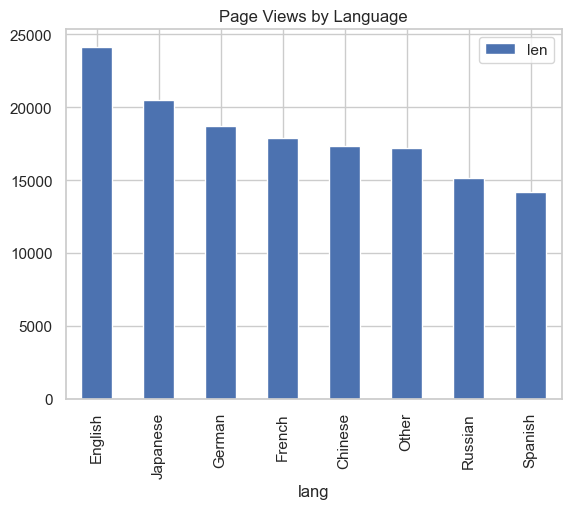

In [151]:
plt.figure(figsize=(10, 8))
cleaned_df.group_by("lang").len().sort("len", descending=True).to_pandas().plot.bar(x="lang", y="len")
plt.title("Page Views by Language");

<Figure size 1000x800 with 0 Axes>

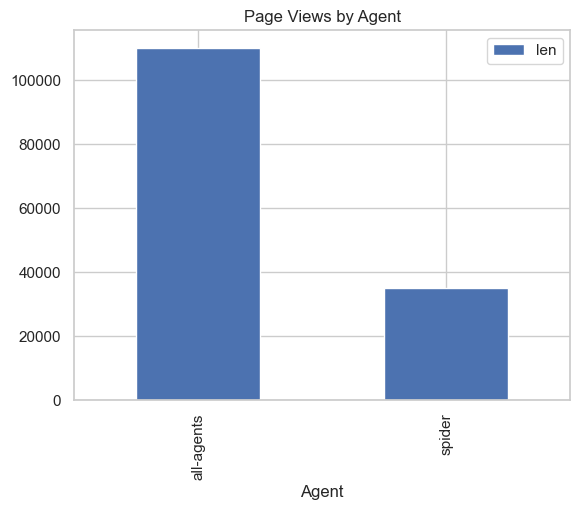

In [134]:
plt.figure(figsize=(10, 8))
cleaned_df.group_by("Agent").len().sort("len", descending=True).to_pandas().plot.bar(x="Agent", y="len")
plt.title("Page Views by Agent");

<Figure size 1000x800 with 0 Axes>

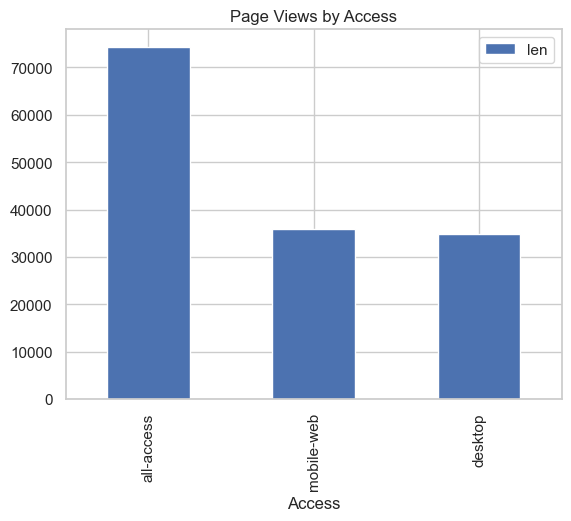

In [135]:
plt.figure(figsize=(10, 8))
cleaned_df.group_by("Access").len().sort("len", descending=True).to_pandas().plot.bar(x="Access", y="len")
plt.title("Page Views by Access");

In [172]:
lang_grp = cleaned_df.group_by("lang").sum().drop("Agent", "Access")
lang_grp

shape: (8, 551)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ lang     ┆ 2015-07-0 ┆ 2015-07-0 ┆ 2015-07-0 ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12-3 │
│ ---      ┆ 1         ┆ 2         ┆ 3         ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 1         │
│ str      ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆ i32       ┆ i32       ┆ i32       ┆   ┆ i32       ┆ i32       ┆ i32       ┆ i32       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Other    ┆ 1477069   ┆ 1548788   ┆ 1464346   ┆ … ┆ 3316427   ┆ 2620026   ┆ 2921474   ┆ 2559123   │
│ Spanish  ┆ 15279998  ┆ 14602449  ┆ 13428998  ┆ … ┆ 16578967  ┆ 15648438  ┆ 11562101  ┆ 11079339  │
│ Japanese ┆ 11864936  ┆ 13622479  ┆ 12307000  ┆ … ┆ 16152145  ┆ 17683587  ┆ 19452390  ┆ 24461932  │
│ English  ┆ 84712323  ┆ 84438676  ┆ 80167807  ┆ … ┆ 141278597 ┆ 150557723 ┆ 125404796 ┆ 123624015 │
│ Chinese  ┆ 4147071   ┆ 4152793   ┆ 4125028   ┆ … ┆ 6515403   ┆ 6044182   ┆ 6114003   ┆ 6300124   │
│ German   ┆ 13264635  ┆ 13084303  ┆ 12558048  ┆ … ┆ 19155875  ┆ 18450782  ┆ 17611564  ┆ 16566864  │
│ Russian  ┆ 9466267   ┆ 9630020   ┆ 8925576   ┆ … ┆ 14002376  ┆ 13480581  ┆ 12069020  ┆ 13224530  │
│ French   ┆ 8460177   ┆ 8514332   ┆ 8187395   ┆ … ┆ 13783146  ┆ 13401250  ┆ 12472948  ┆ 11505867  │
└──────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [176]:
df=lang_grp.unpivot(index="lang", variable_name="dates").pivot("lang", index="dates")
df=df.with_columns(
    pl.col("dates").cast(pl.Date),
)

In [177]:
campaign_df = pl.read_csv("../data/processed/Exog_Campaign_eng.csv", has_header=True, ignore_errors=True)
campaign_df

shape: (550, 1)
┌──────┐
│ Exog │
│ ---  │
│ i64  │
╞══════╡
│ 0    │
│ 0    │
│ 0    │
│ 0    │
│ 0    │
│ …    │
│ 1    │
│ 1    │
│ 1    │
│ 0    │
│ 0    │
└──────┘

In [178]:
df=df.hstack(campaign_df)
df.head(10)

shape: (10, 10)
┌────────────┬─────────┬──────────┬──────────┬───┬──────────┬──────────┬─────────┬──────┐
│ dates      ┆ Other   ┆ Spanish  ┆ Japanese ┆ … ┆ German   ┆ Russian  ┆ French  ┆ Exog │
│ ---        ┆ ---     ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---     ┆ ---  │
│ date       ┆ i32     ┆ i32      ┆ i32      ┆   ┆ i32      ┆ i32      ┆ i32     ┆ i64  │
╞════════════╪═════════╪══════════╪══════════╪═══╪══════════╪══════════╪═════════╪══════╡
│ 2015-07-01 ┆ 1477069 ┆ 15279998 ┆ 11864936 ┆ … ┆ 13264635 ┆ 9466267  ┆ 8460177 ┆ 0    │
│ 2015-07-02 ┆ 1548788 ┆ 14602449 ┆ 13622479 ┆ … ┆ 13084303 ┆ 9630020  ┆ 8514332 ┆ 0    │
│ 2015-07-03 ┆ 1464346 ┆ 13428998 ┆ 12307000 ┆ … ┆ 12558048 ┆ 8925576  ┆ 8187395 ┆ 0    │
│ 2015-07-04 ┆ 1249447 ┆ 12607803 ┆ 15457627 ┆ … ┆ 11523603 ┆ 8395377  ┆ 8750945 ┆ 0    │
│ 2015-07-05 ┆ 1385036 ┆ 13711974 ┆ 14828618 ┆ … ┆ 13395805 ┆ 8940768  ┆ 8591590 ┆ 0    │
│ 2015-07-06 ┆ 1586847 ┆ 15627539 ┆ 12922630 ┆ … ┆ 14746420 ┆ 9631695  ┆ 8951425 ┆ 0    │
│ 2015-07-07 ┆ 1679560 ┆ 15232641 ┆ 12570816 ┆ … ┆ 14301345 ┆ 9411165  ┆ 8652420 ┆ 0    │
│ 2015-07-08 ┆ 1755740 ┆ 14783419 ┆ 12494311 ┆ … ┆ 14509892 ┆ 9366525  ┆ 8493256 ┆ 0    │
│ 2015-07-09 ┆ 1530950 ┆ 14504467 ┆ 12179762 ┆ … ┆ 13968844 ┆ 9594537  ┆ 8405132 ┆ 0    │
│ 2015-07-10 ┆ 1547281 ┆ 13185904 ┆ 12654331 ┆ … ┆ 13018538 ┆ 10987503 ┆ 7932023 ┆ 0    │
└────────────┴─────────┴──────────┴──────────┴───┴──────────┴──────────┴─────────┴──────┘

In [179]:
df.write_parquet("../data/processed/df.parquet")

# EDA

In [84]:
df=pl.read_parquet("../data/processed/df.parquet").to_pandas()

In [85]:
df=df.set_index("dates")
df=df.drop("Other", axis=1)
df

Spanish  Japanese    English  ...   Russian    French  Exog
dates                                      ...                          
2015-07-01  15279998  11864936   84712323  ...   9466267   8460177     0
2015-07-02  14602449  13622479   84438676  ...   9630020   8514332     0
2015-07-03  13428998  12307000   80167807  ...   8925576   8187395     0
2015-07-04  12607803  15457627   83463351  ...   8395377   8750945     0
2015-07-05  13711974  14828618   86198774  ...   8940768   8591590     0
...              ...       ...        ...  ...       ...       ...   ...
2016-12-27  15946677  16124459  145628953  ...  15041813  15282895     1
2016-12-28  16578967  16152145  141278597  ...  14002376  13783146     1
2016-12-29  15648438  17683587  150557723  ...  13480581  13401250     1
2016-12-30  11562101  19452390  125404796  ...  12069020  12472948     0
2016-12-31  11079339  24461932  123624015  ...  13224530  11505867     0

[550 rows x 8 columns]

In [36]:
columns = ['Spanish', 'Japanese', 'English', 'Chinese', 'German', 'Russian', 'French']

In [37]:
columns

['Spanish', 'Japanese', 'English', 'Chinese', 'German', 'Russian', 'French']

In [86]:
df["Exog_scaled"] = df["Exog"]*df["English"]
filtered_df = df[df["Exog_scaled"] > 0]
df=df.drop("Exog_scaled", axis=1)

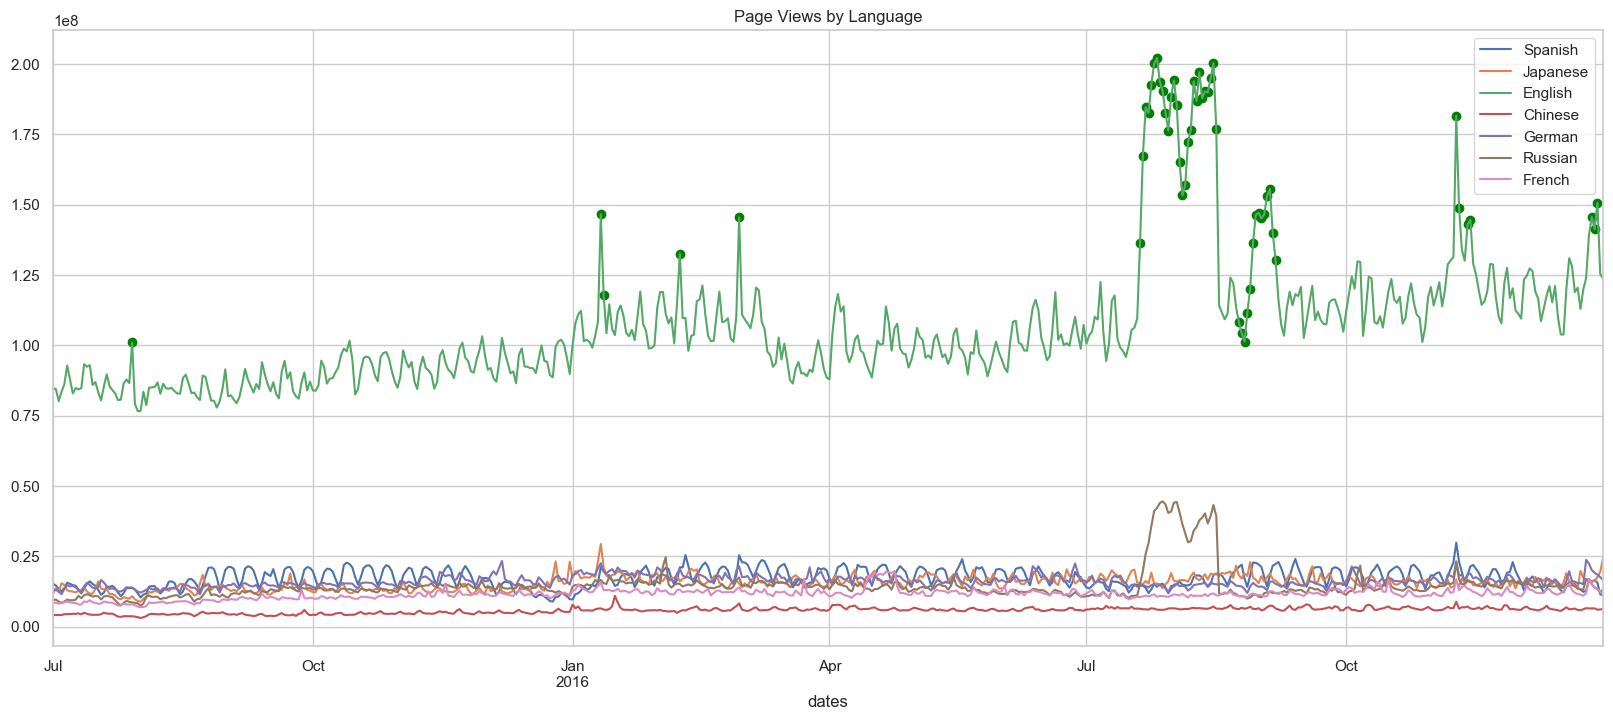

In [87]:
df.drop(["Exog"], axis=1).plot(figsize=(20, 8));
plt.scatter(filtered_df.index, filtered_df["Exog_scaled"], color="green", label="Exog_scaled")
plt.title("Page Views by Language");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that English language has highest number of page views.
- We can also see a surge in views in the month of August for English and Russian languages.
- This can be due to the campaigns run

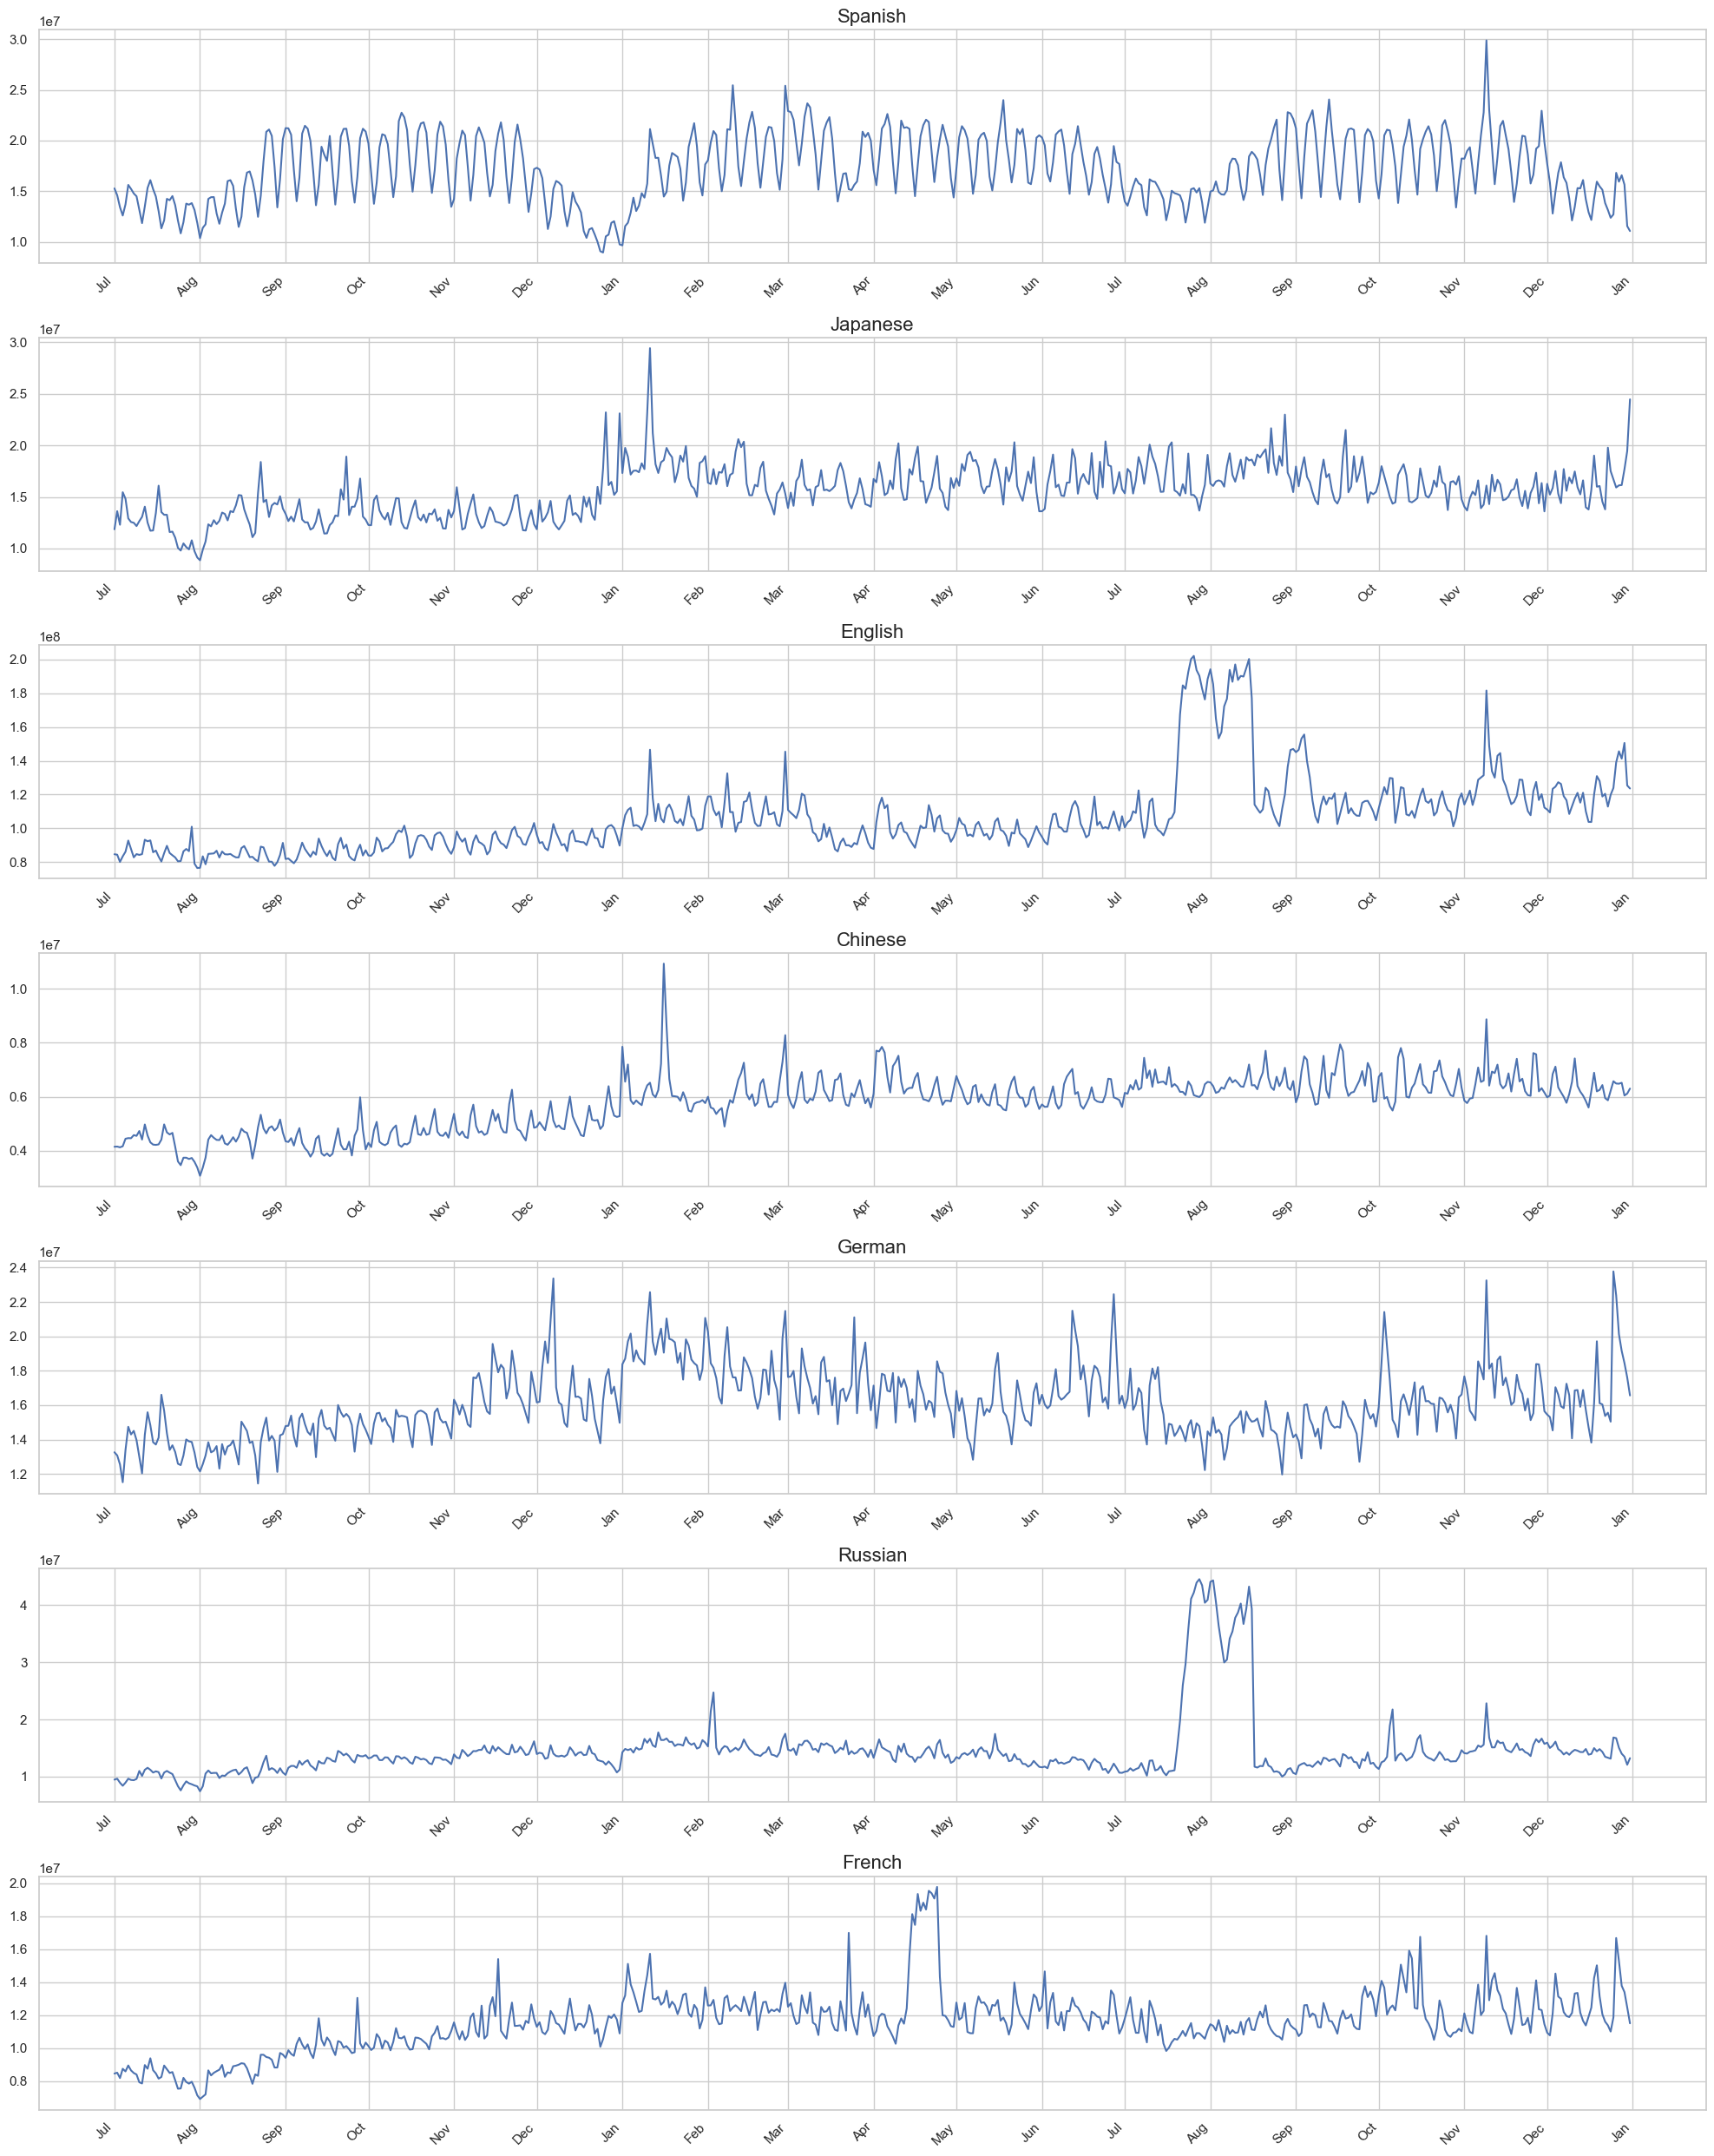

In [41]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(len(columns), 1, figsize=(20, 25))

for i, col in enumerate(columns):
    ax[i].plot(df[col])
    ax[i].set_title(col, fontsize=16)
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

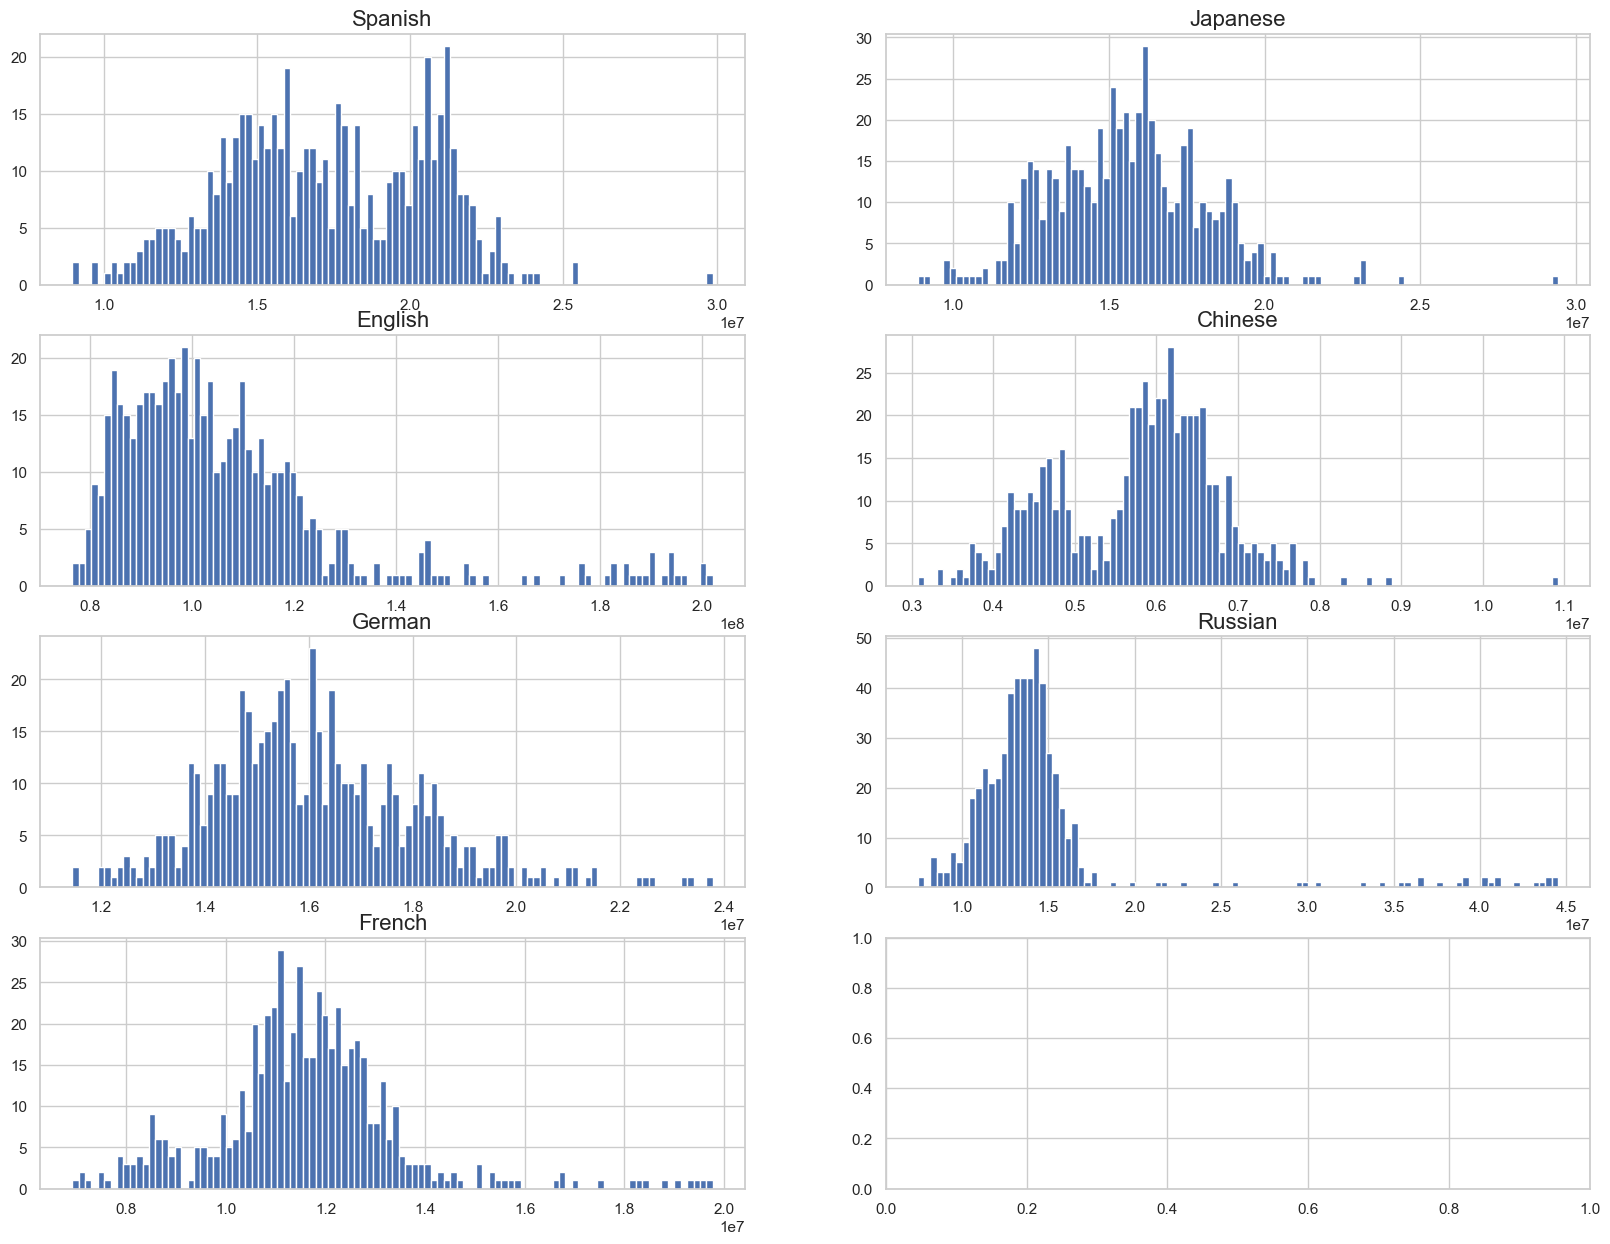

In [42]:
fig, ax = plt.subplots(4, 2, figsize=(20, 15))

for i, col in enumerate(columns):
    df[col].hist(ax=ax[i//2, i%2], bins=100)
    ax[i//2, i%2].set_title(col, fontsize=16)
# plt.tight_layout()


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see that Russian has large number of outliers

# Stationarity Check



## AD Fuller Test

In [46]:
def is_stationary(series, significance_level=0.05):
    adf_test = adfuller(series)
    p_value = adf_test[1]
    return p_value < significance_level , p_value

In [48]:
adf_df = pd.DataFrame(columns=["Lang", "p-value", "is_stationary"])

for column in columns:
    result, p_value = is_stationary(df[column])
    adf_df = pd.concat([adf_df, pd.DataFrame({"Lang": [column], "p-value": p_value, "is_stationary": result})], ignore_index=True)

adf_df.sort_values("p-value", ascending=False)

C:\Users\v-gautamnaik\AppData\Local\Temp\ipykernel_7352\3790388776.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  adf_df = pd.concat([adf_df, pd.DataFrame({"Lang": [column], "p-value": p_value, "is_stationary": result})], ignore_index=True)


Lang   p-value is_stationary
3   Chinese  0.447261         False
2   English  0.189574         False
4    German  0.139171         False
1  Japanese  0.102580         False
6    French  0.051539         False
0   Spanish  0.033589          True
5   Russian  0.001864          True

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

Above table shows which language time series is stationary and which is not. 

## Decomposition

**English**

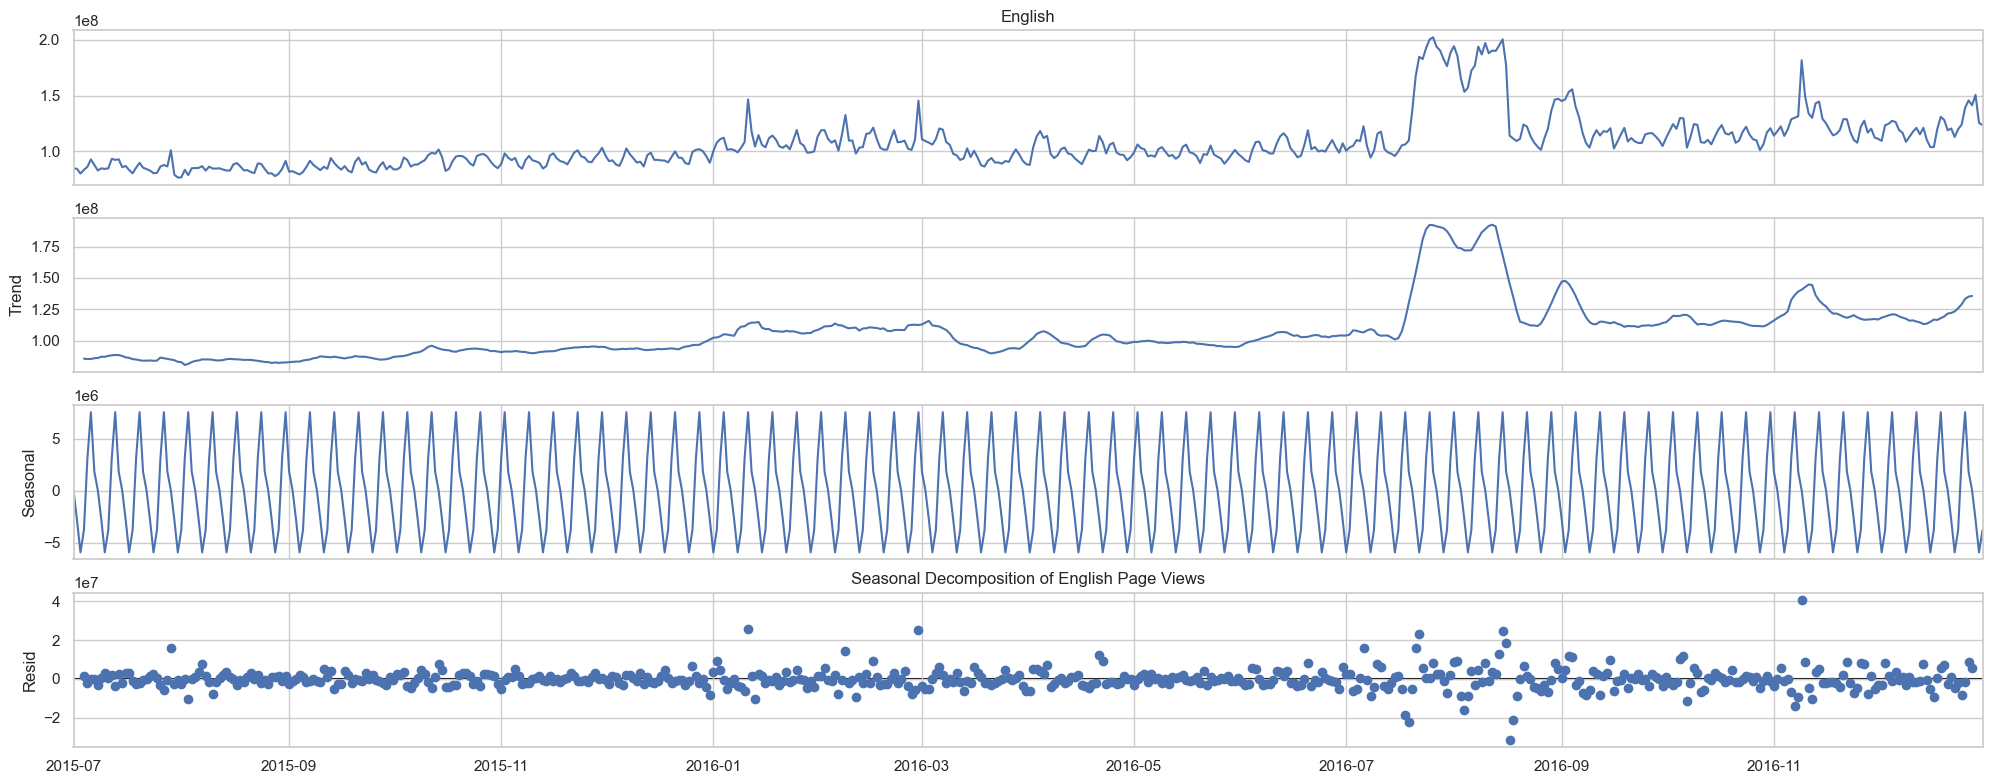

In [48]:
plt.rcParams['figure.figsize'] = (20, 8)
seasonal_decompose(df["English"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is upward trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are spread around 0 suggesting no underlying trend

**Spanish**

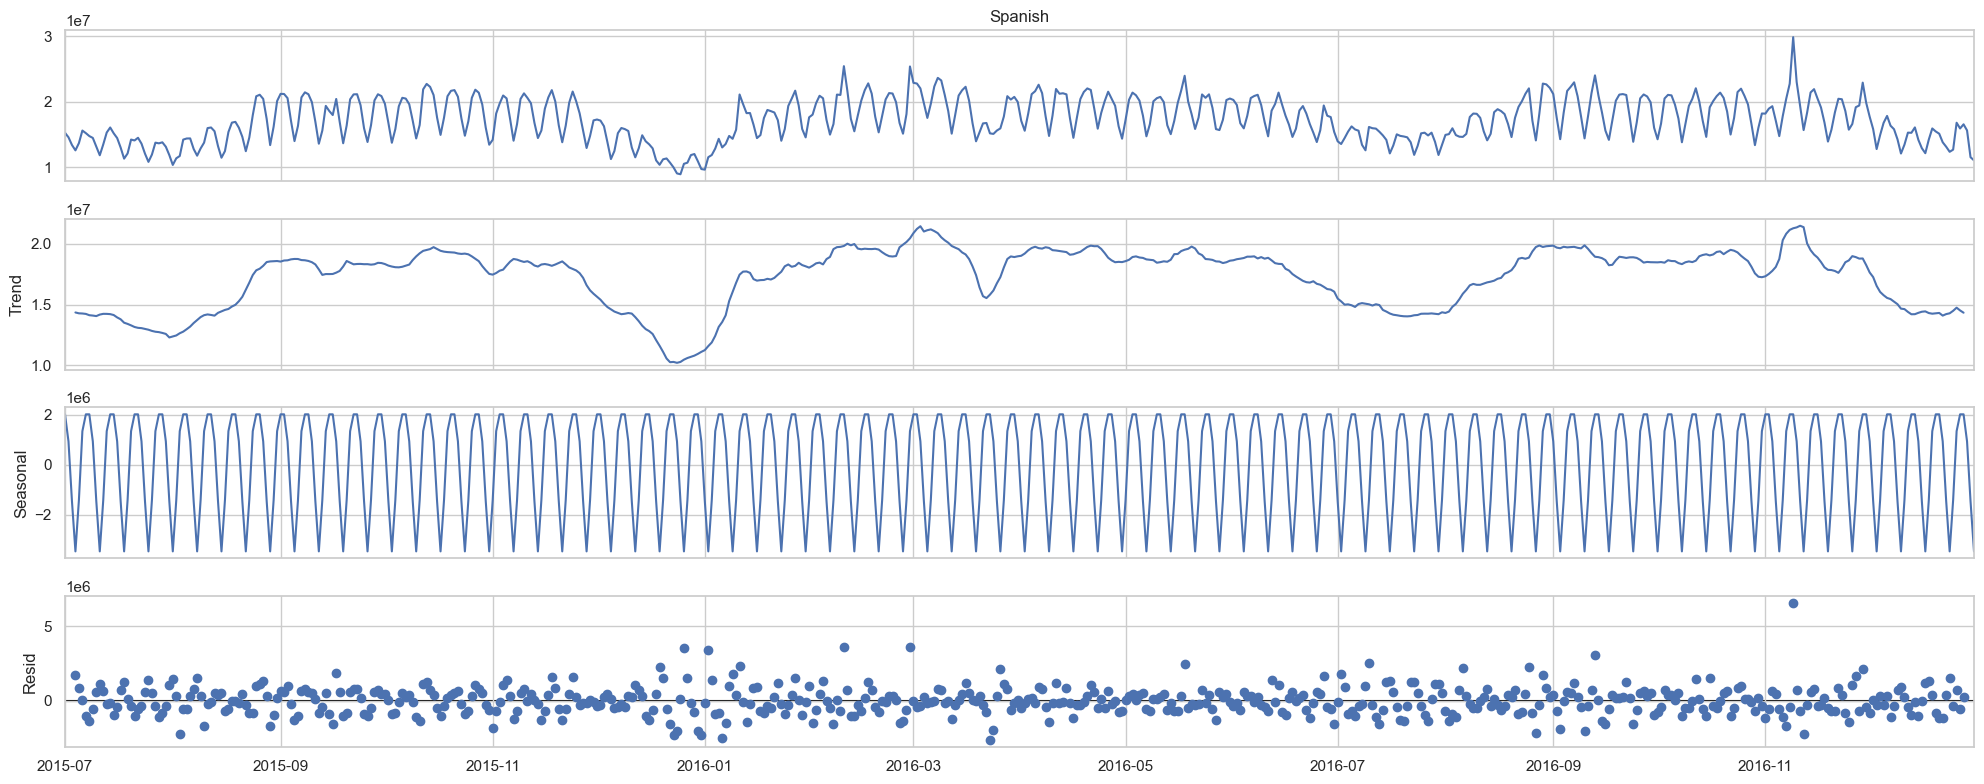

In [50]:
seasonal_decompose(df["Spanish"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is no trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are spread around 0 suggesting no underlying trend

**Russian**

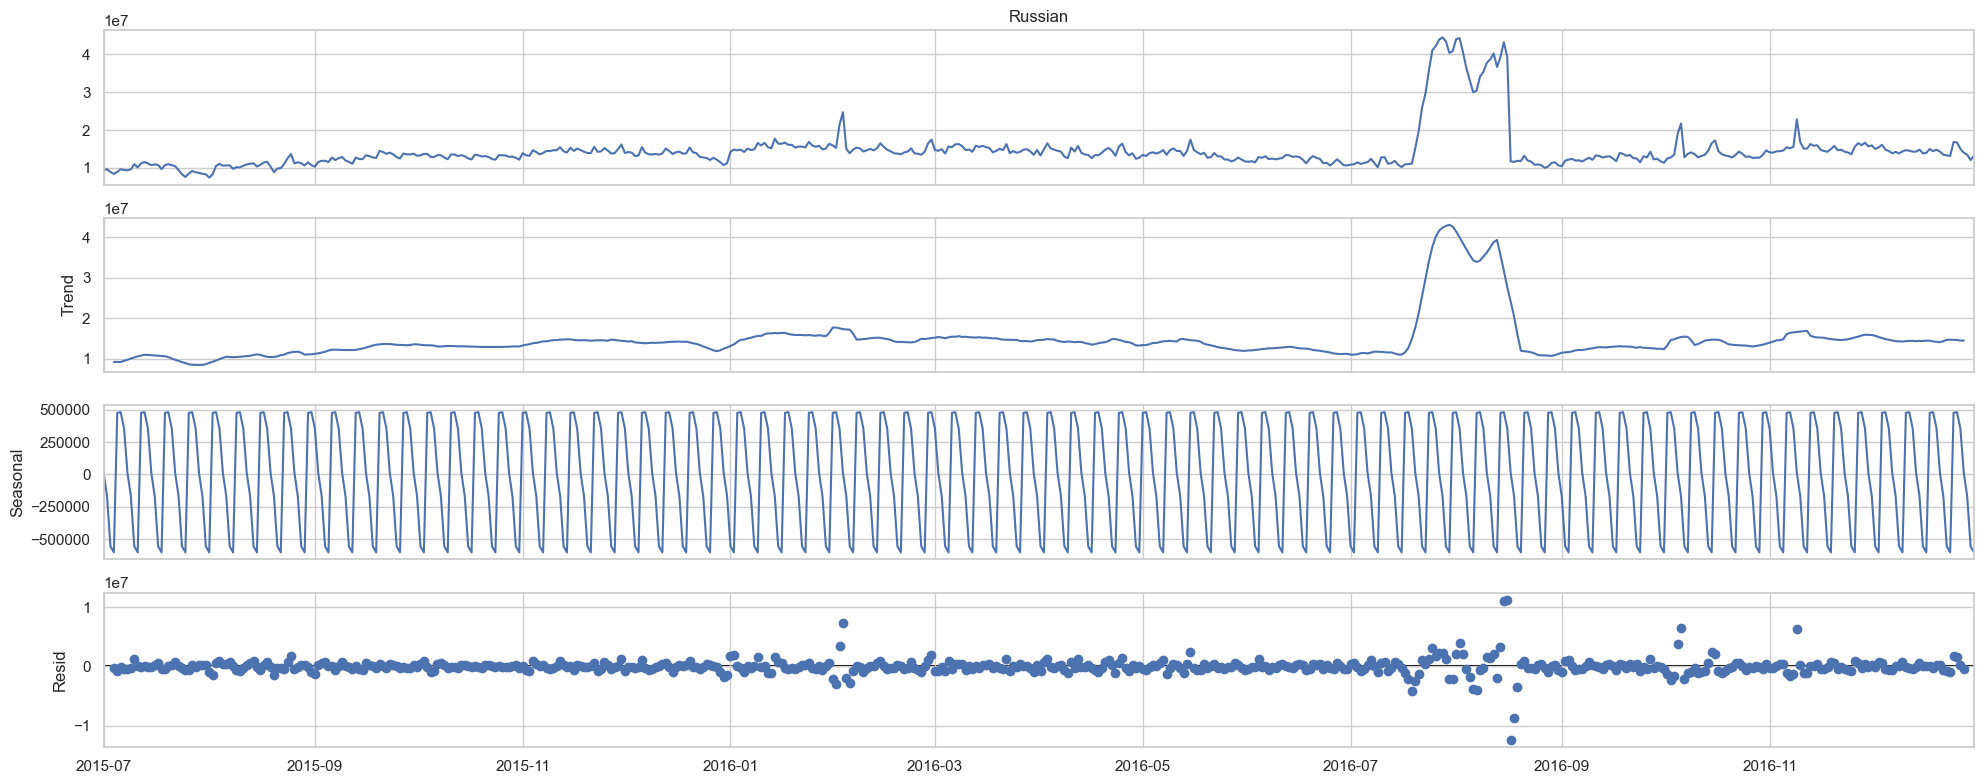

In [52]:
seasonal_decompose(df["Russian"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is small trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are tightly spread around 0 suggesting no underlying trend

**Japanese**

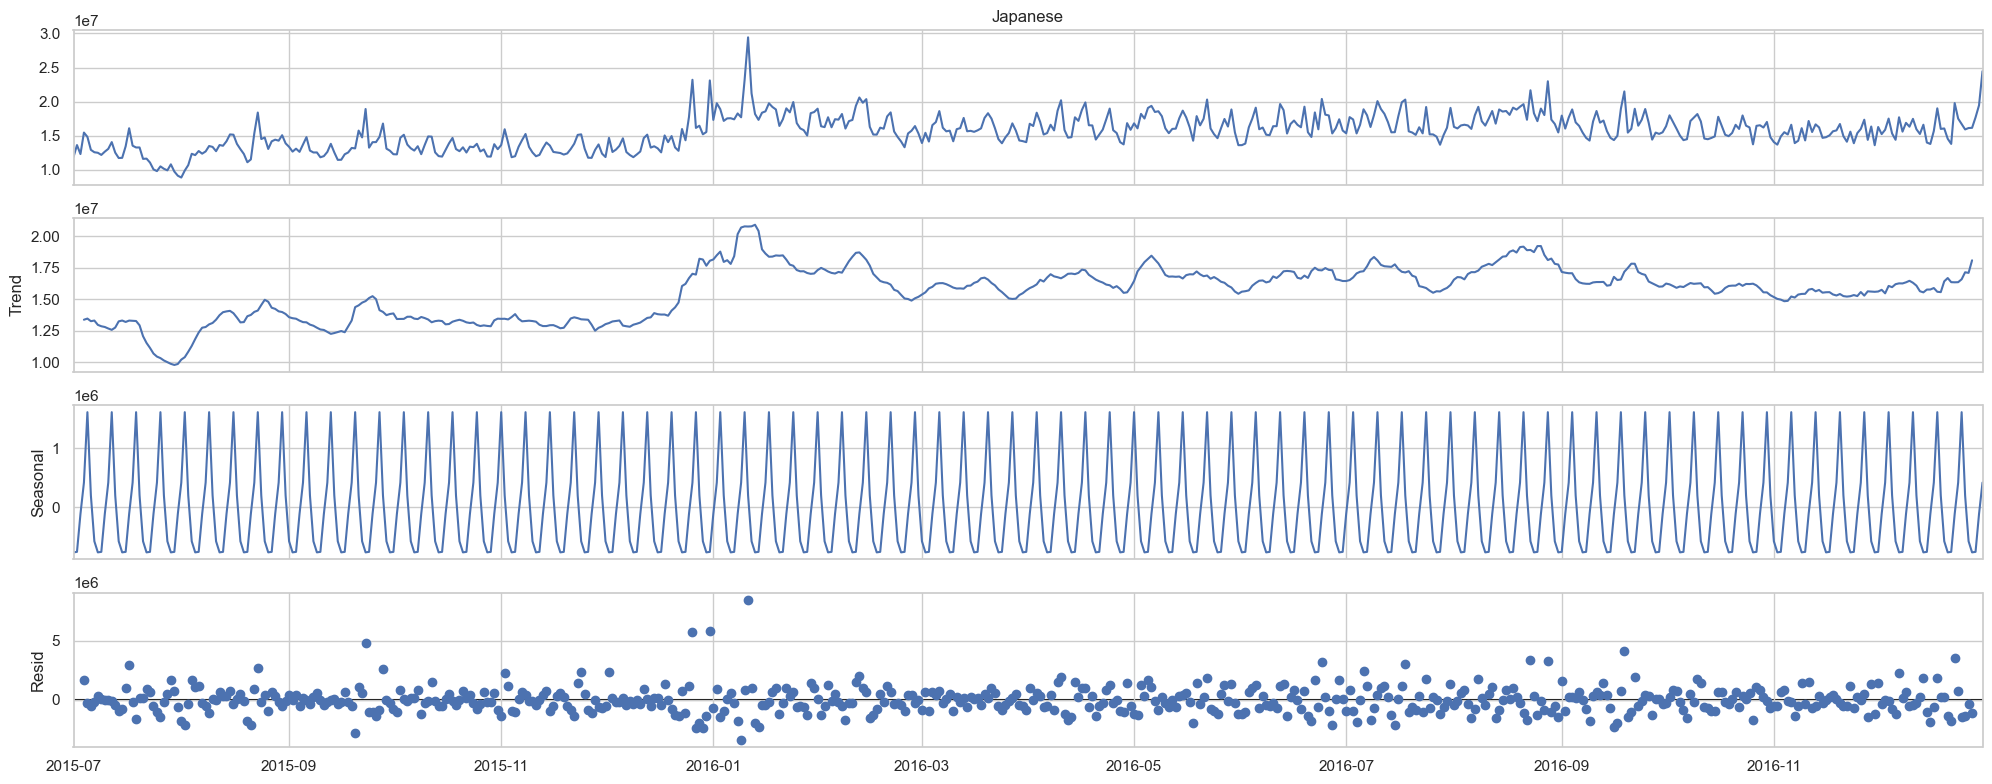

In [54]:
seasonal_decompose(df["Japanese"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there was a jump in view but then it is constant
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

**French**

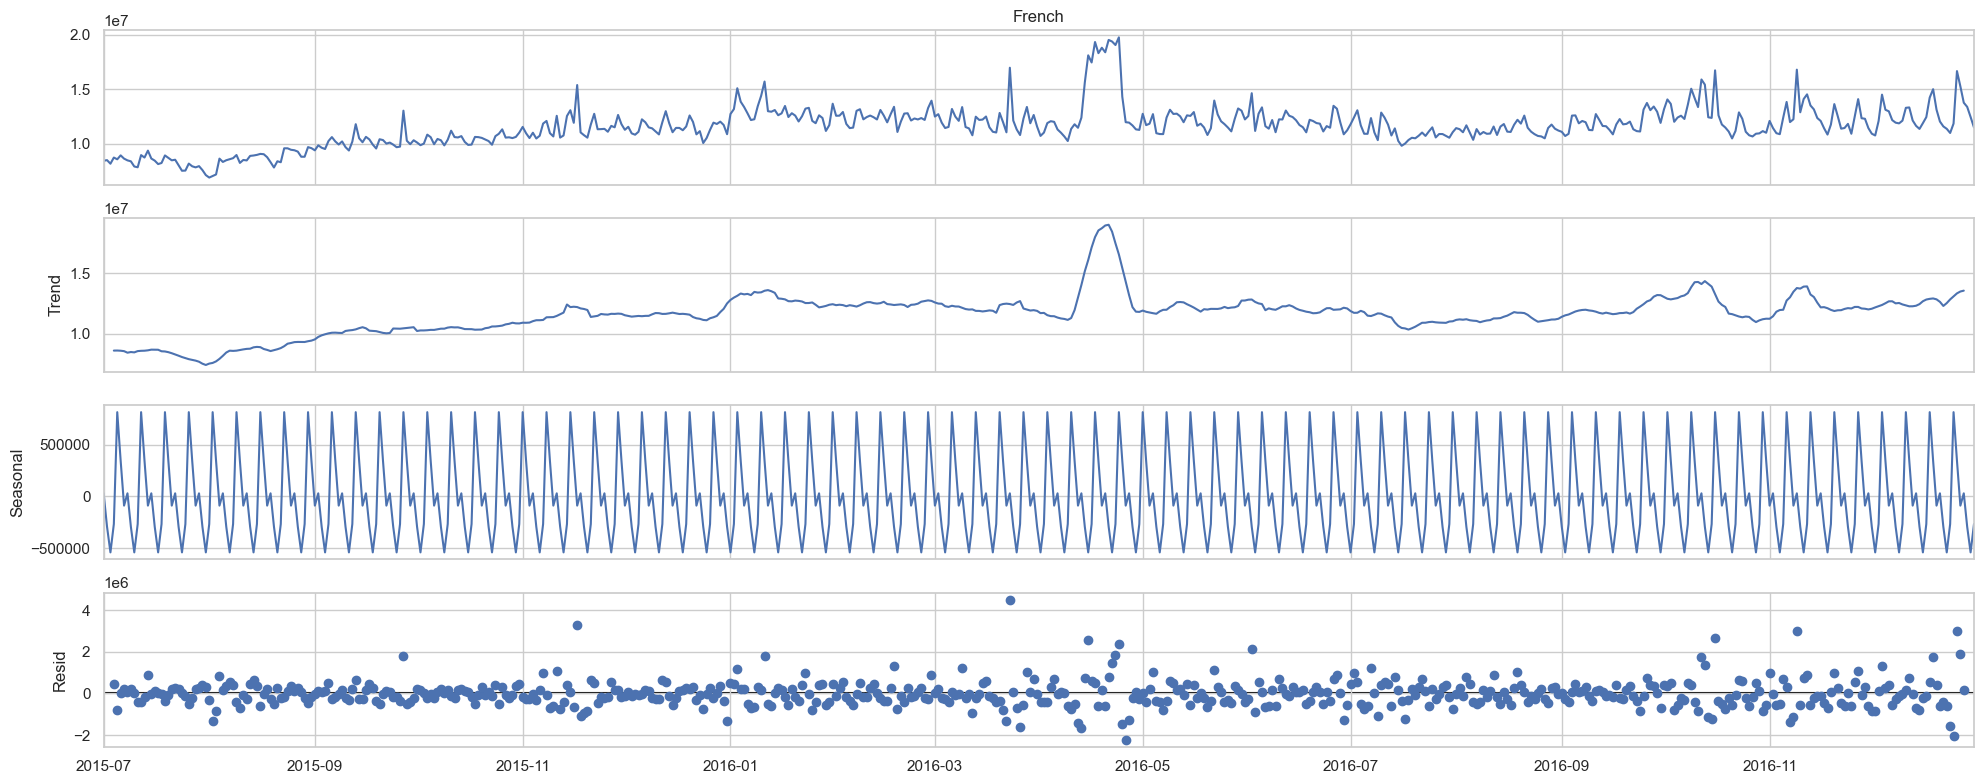

In [56]:
seasonal_decompose(df["French"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is small trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

**German**

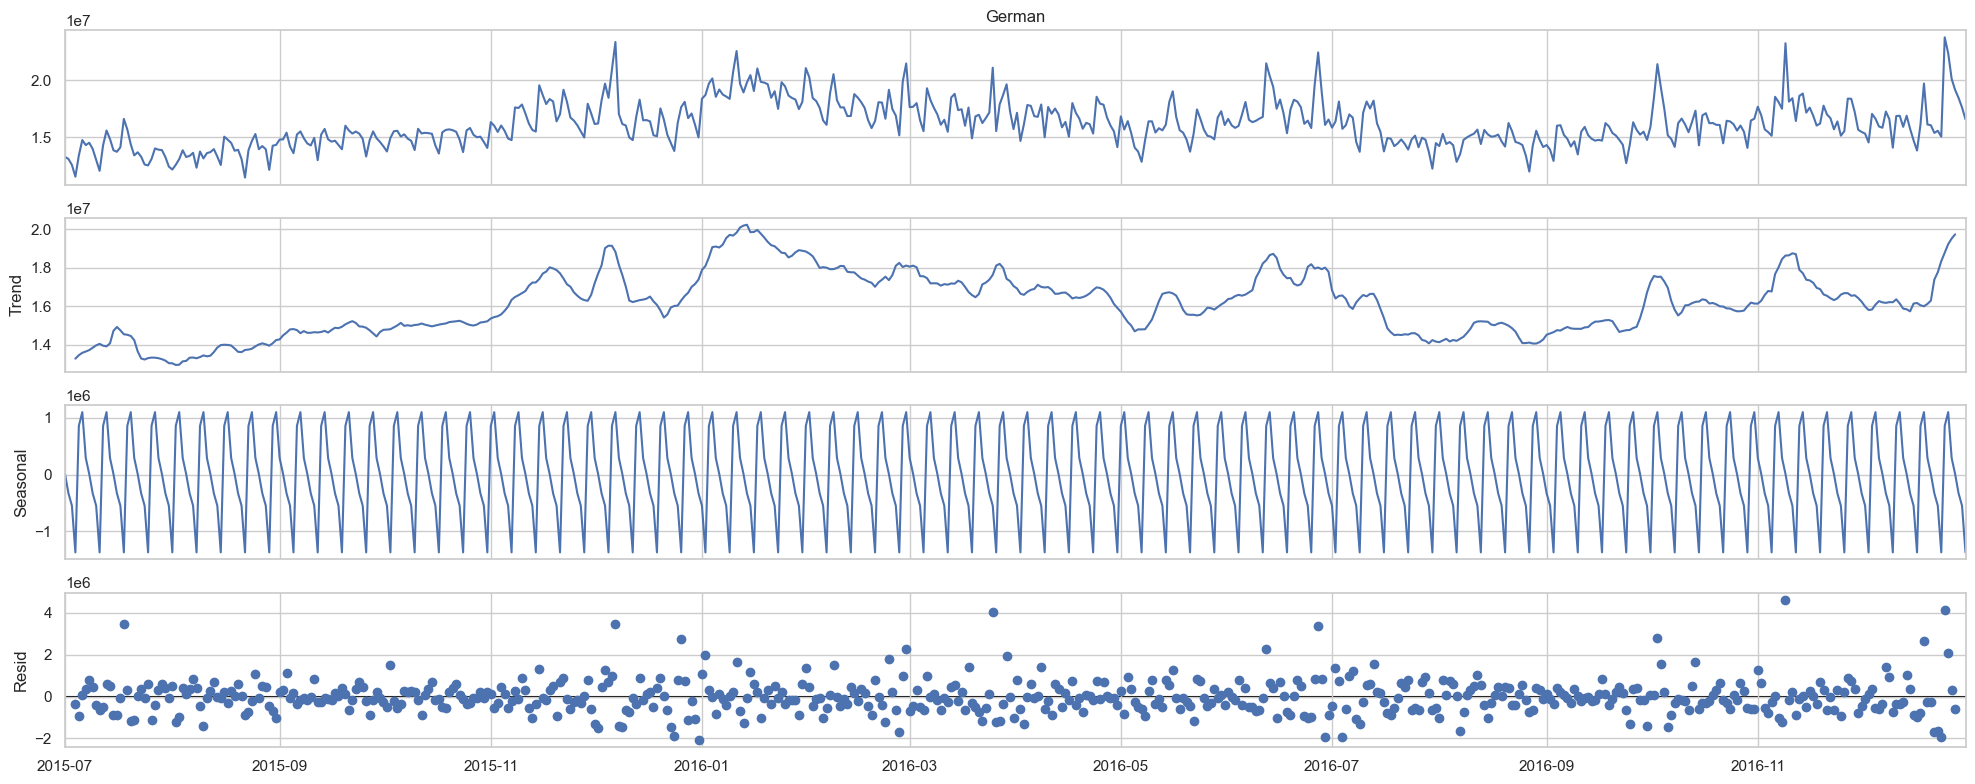

In [57]:
seasonal_decompose(df["German"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there are ups and downs in the page views count but no clear trend
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

**Chinese**

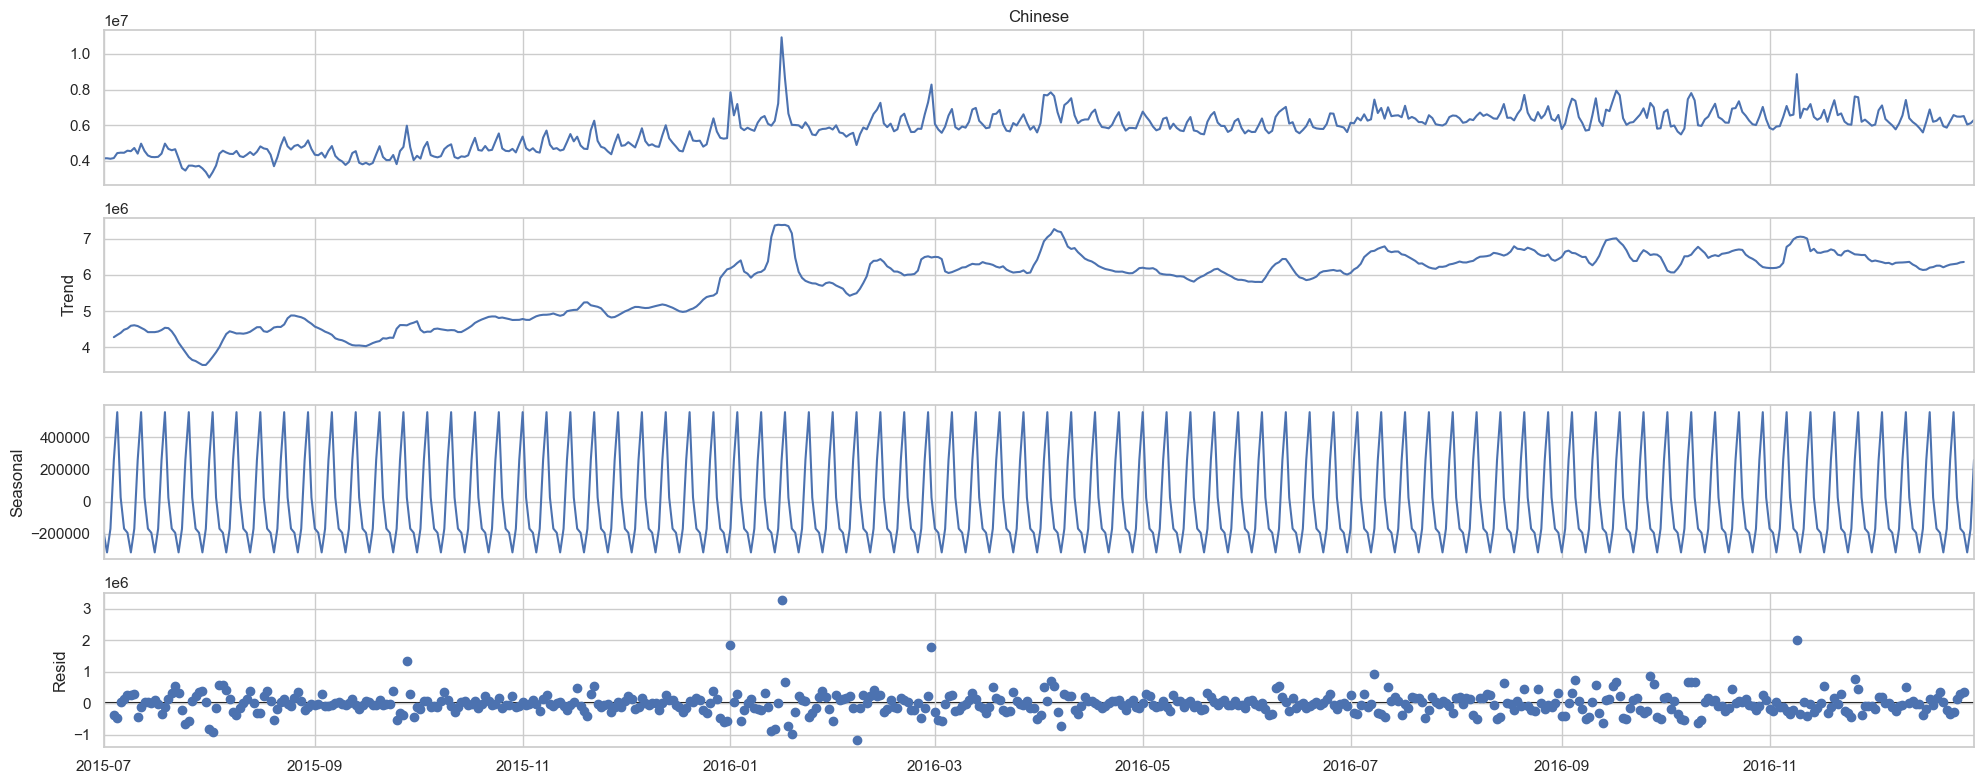

In [58]:
seasonal_decompose(df["Chinese"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there was a jump in view but then it is constant
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

# Differencing

In [88]:
df_st = df.copy()

In [89]:
df_st[columns] = df_st[columns].diff()

In [90]:
df_st=df_st.dropna()
df_st

Spanish   Japanese     English  ...    Russian     French  Exog
dates                                         ...                            
2015-07-02  -677549.0  1757543.0   -273647.0  ...   163753.0    54155.0     0
2015-07-03 -1173451.0 -1315479.0  -4270869.0  ...  -704444.0  -326937.0     0
2015-07-04  -821195.0  3150627.0   3295544.0  ...  -530199.0   563550.0     0
2015-07-05  1104171.0  -629009.0   2735423.0  ...   545391.0  -159355.0     0
2015-07-06  1915565.0 -1905988.0   6610795.0  ...   690927.0   359835.0     0
...               ...        ...         ...  ...        ...        ...   ...
2016-12-27  -873730.0   205396.0   6516584.0  ... -1676938.0 -1396984.0     1
2016-12-28   632290.0    27686.0  -4350356.0  ... -1039437.0 -1499749.0     1
2016-12-29  -930529.0  1531442.0   9279126.0  ...  -521795.0  -381896.0     1
2016-12-30 -4086337.0  1768803.0 -25152927.0  ... -1411561.0  -928302.0     0
2016-12-31  -482762.0  5009542.0  -1780781.0  ...  1155510.0  -967081.0     0

[549 rows x 8 columns]

In [76]:
adf_df = pd.DataFrame(columns=["Lang", "p-value", "is_stationary"])

for column in columns:
    result, p_value = is_stationary(df_st[column])
    adf_df = pd.concat([adf_df, pd.DataFrame({"Lang": [column], "p-value": p_value, "is_stationary": result})], ignore_index=True)

adf_df.sort_values("p-value", ascending=False)

C:\Users\v-gautamnaik\AppData\Local\Temp\ipykernel_7352\1076179733.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  adf_df = pd.concat([adf_df, pd.DataFrame({"Lang": [column], "p-value": p_value, "is_stationary": result})], ignore_index=True)


Lang       p-value is_stationary
0   Spanish  1.499282e-07          True
4    German  2.488111e-10          True
3   Chinese  1.175377e-11          True
2   English  5.285073e-13          True
6    French  1.056177e-17          True
1  Japanese  6.206743e-20          True
5   Russian  2.485269e-30          True

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- After applying differencing we can see that all the languages are stationary

# ACF and PACF

In [2]:
params={}
# params["Spanish"] = {
#     "order": (1, 1, 1), p: AR -> PACF , d: Difference, q: MA -> ACF
#     "seasonal_order": (1, 1, 1, 12), P: Seasonal AR, D: Seasonal Difference, Q: Seasonal MA, m: Seasonal Period
# }

In [4]:
df_st=pd.read_parquet("../data/processed/df_st.parquet")

**English**

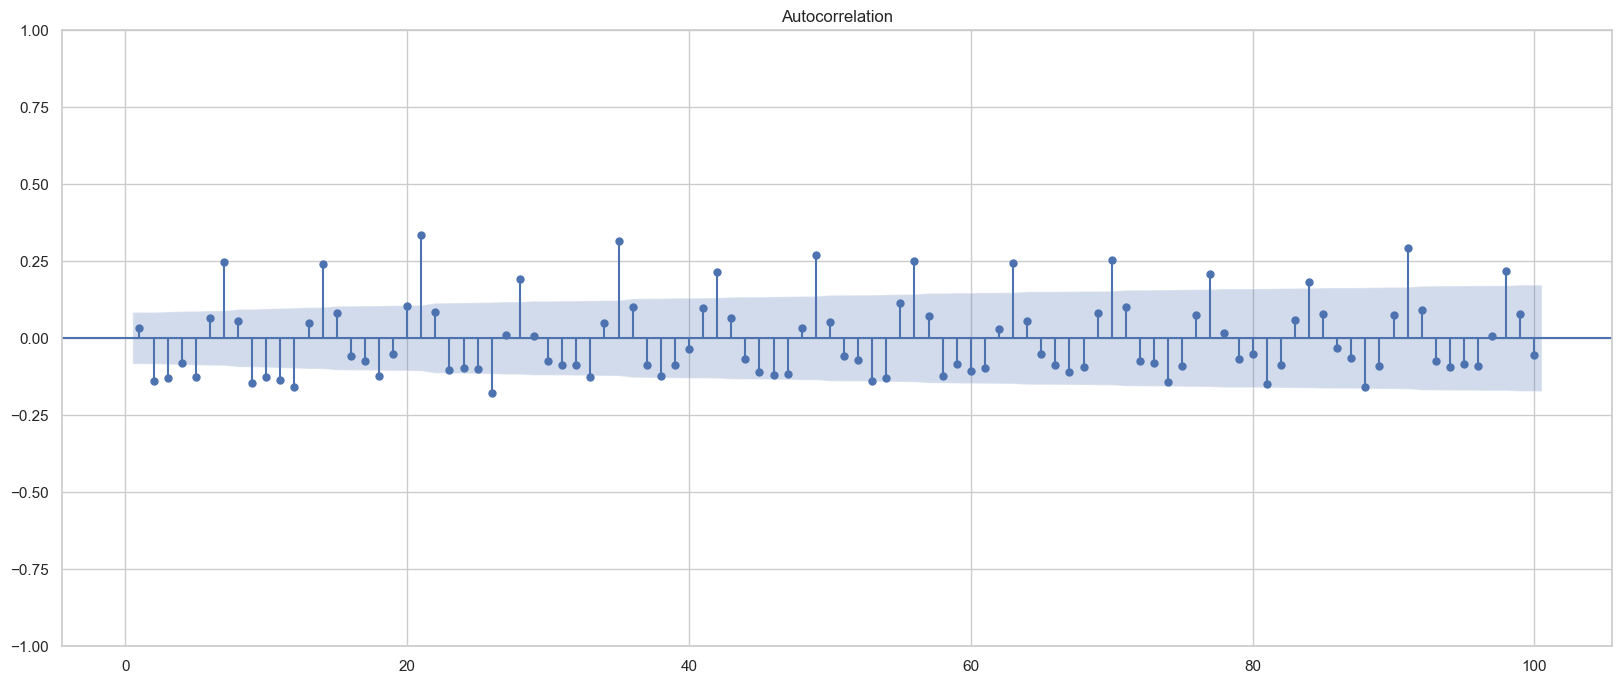

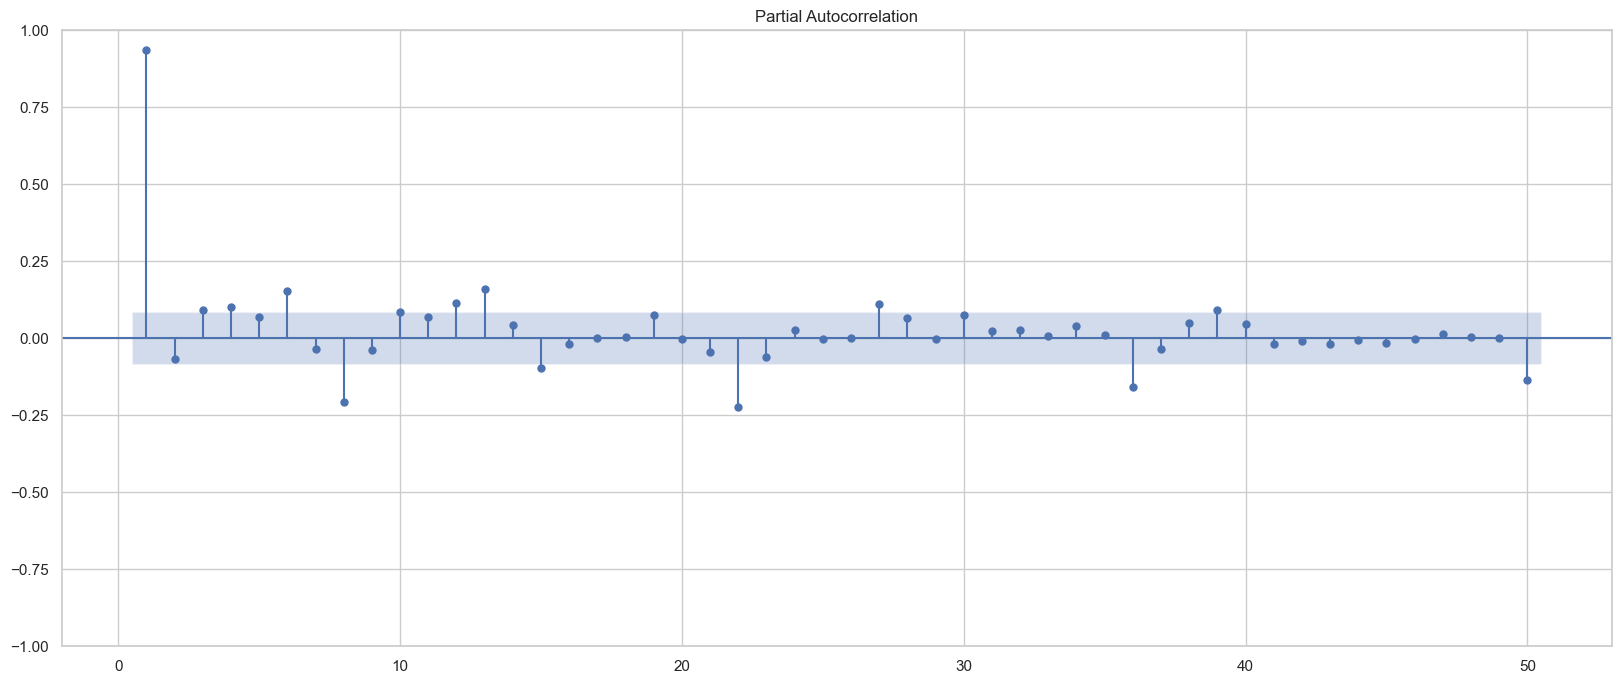

In [77]:
plt.rcParams['figure.figsize'] = (20, 8)
plot_acf(df_st["English"], lags=100, zero=False);
plot_pacf(df["English"], lags=50, zero=False);

In [37]:
params["English"] = {
    "order": (9, 1, 6),
    "seasonal_order": (7, 0, 7, 7),
}

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>



**Spanish**

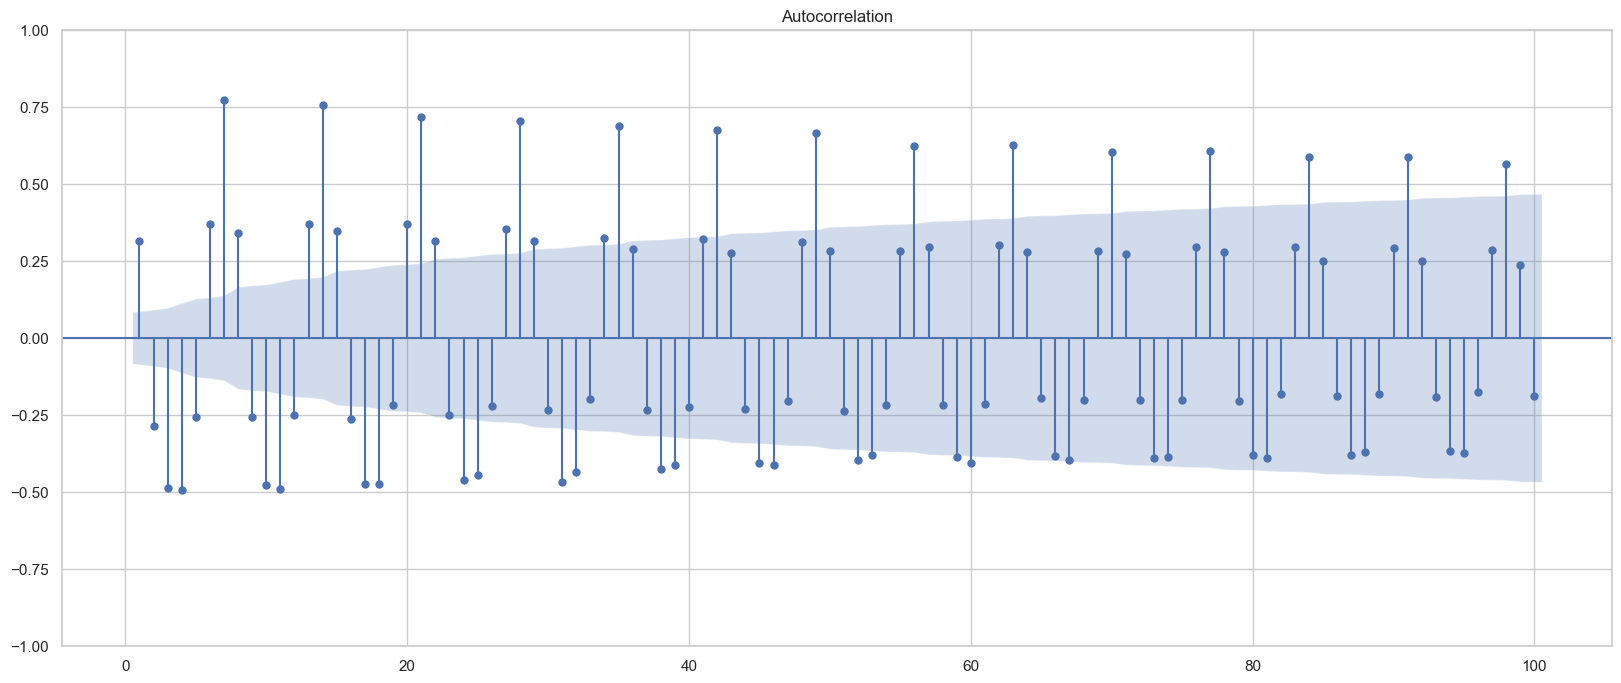

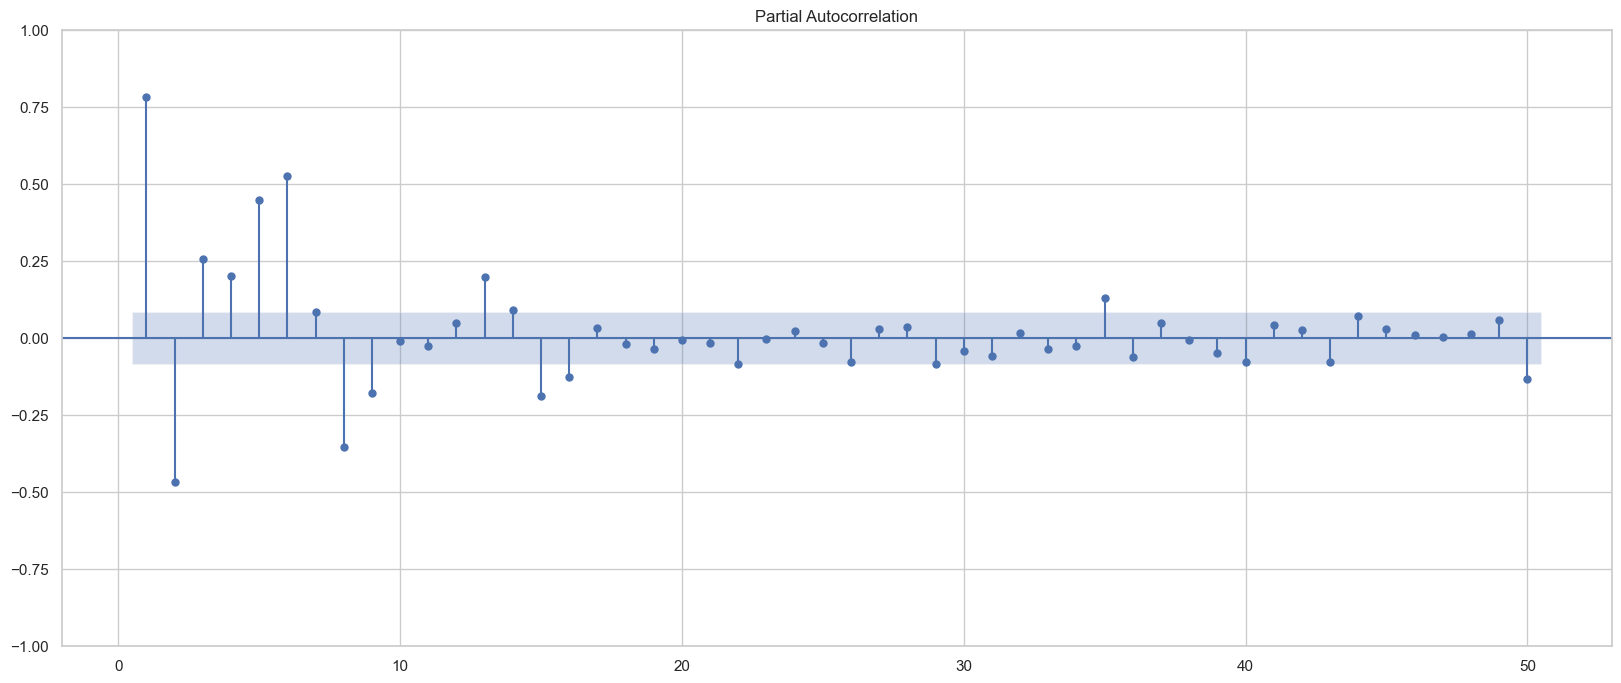

In [78]:
plot_acf(df_st["Spanish"], lags=100, zero=False);
plot_pacf(df["Spanish"], lags=50, zero=False);

In [4]:
params["Spanish"] = {
    "order": (6, 1, 7),
    "seasonal_order": (1, 1, 1, 12),
}

**Russian**

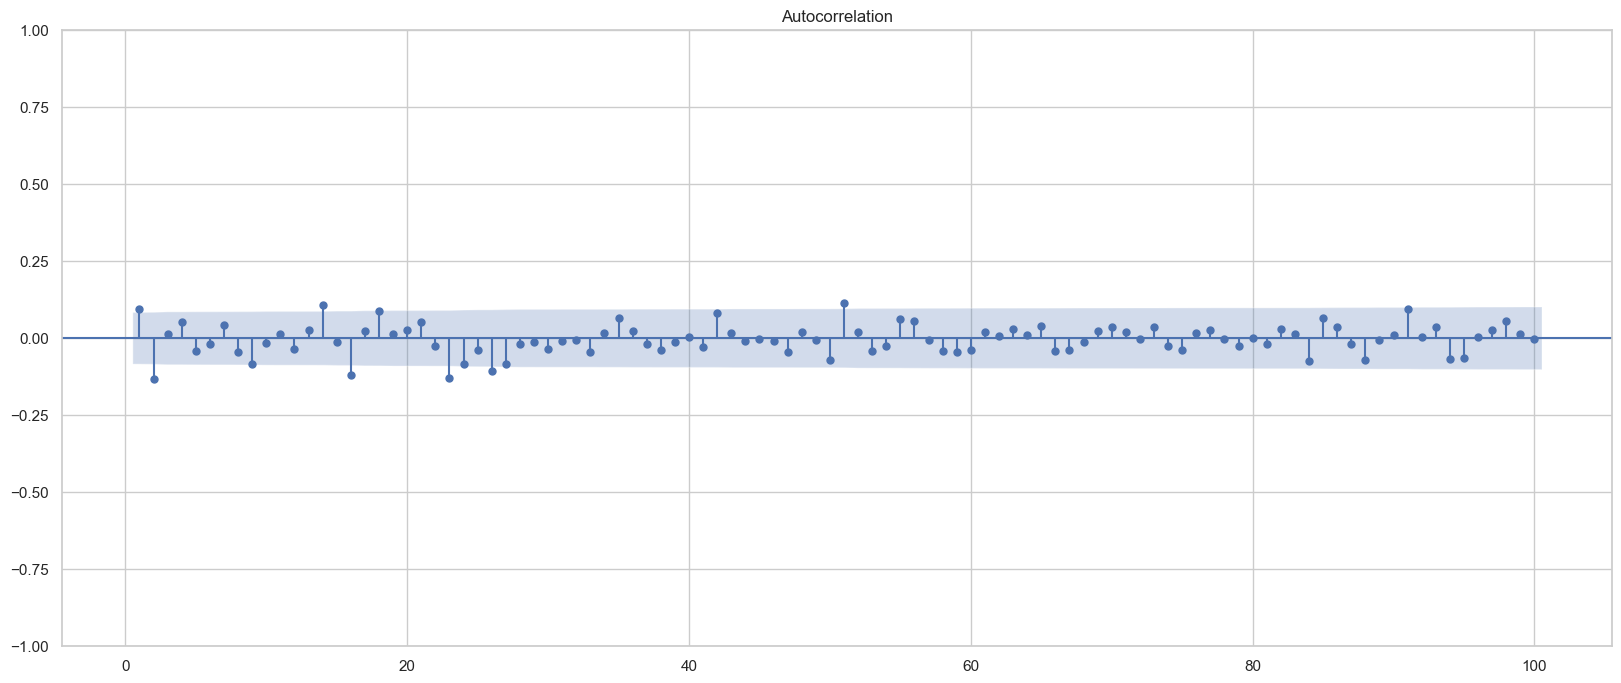

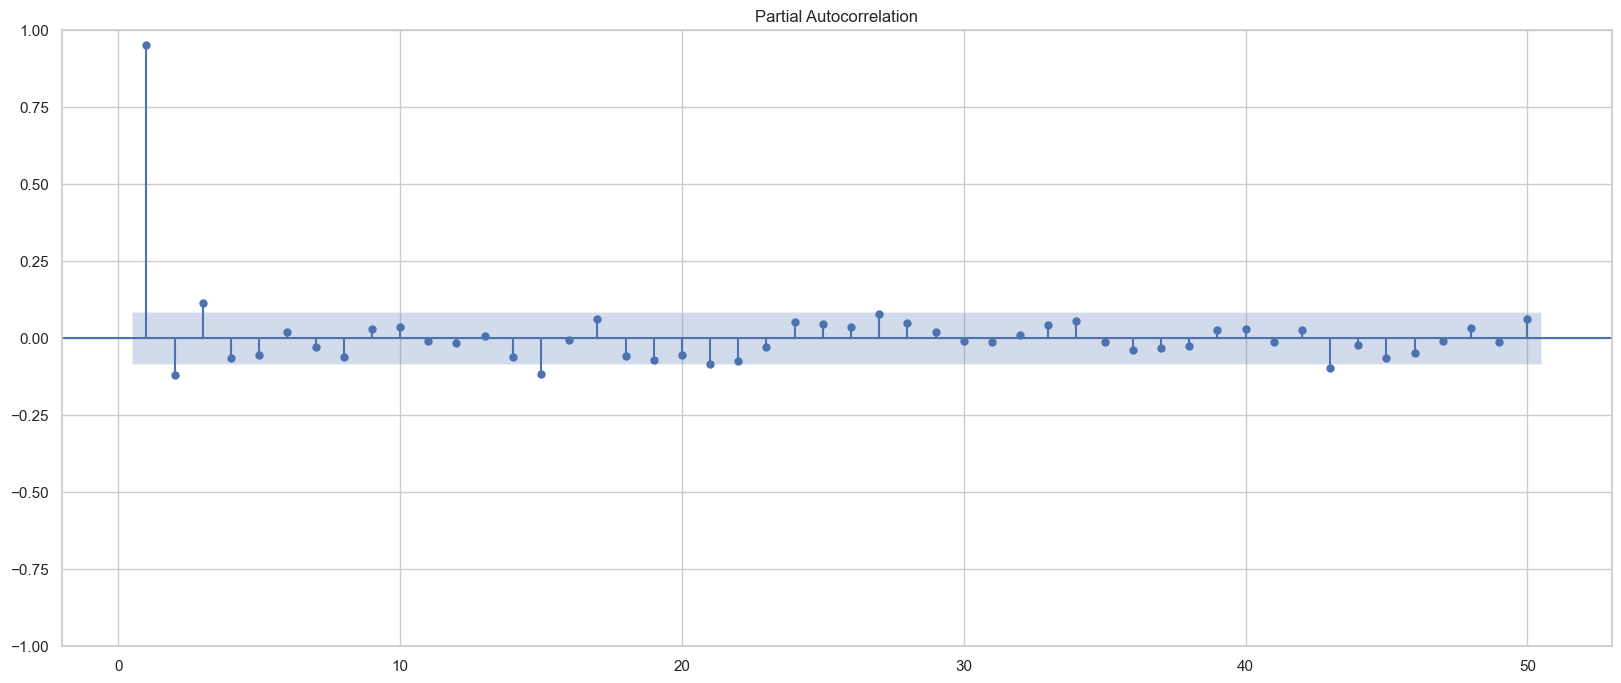

In [79]:
plot_acf(df_st["Russian"], lags=100, zero=False);
plot_pacf(df["Russian"], lags=50, zero=False);

In [5]:
params["Russian"] = {
    "order": (3, 1, 2),
    "seasonal_order": (1, 1, 1, 12),
}


**Japanese**


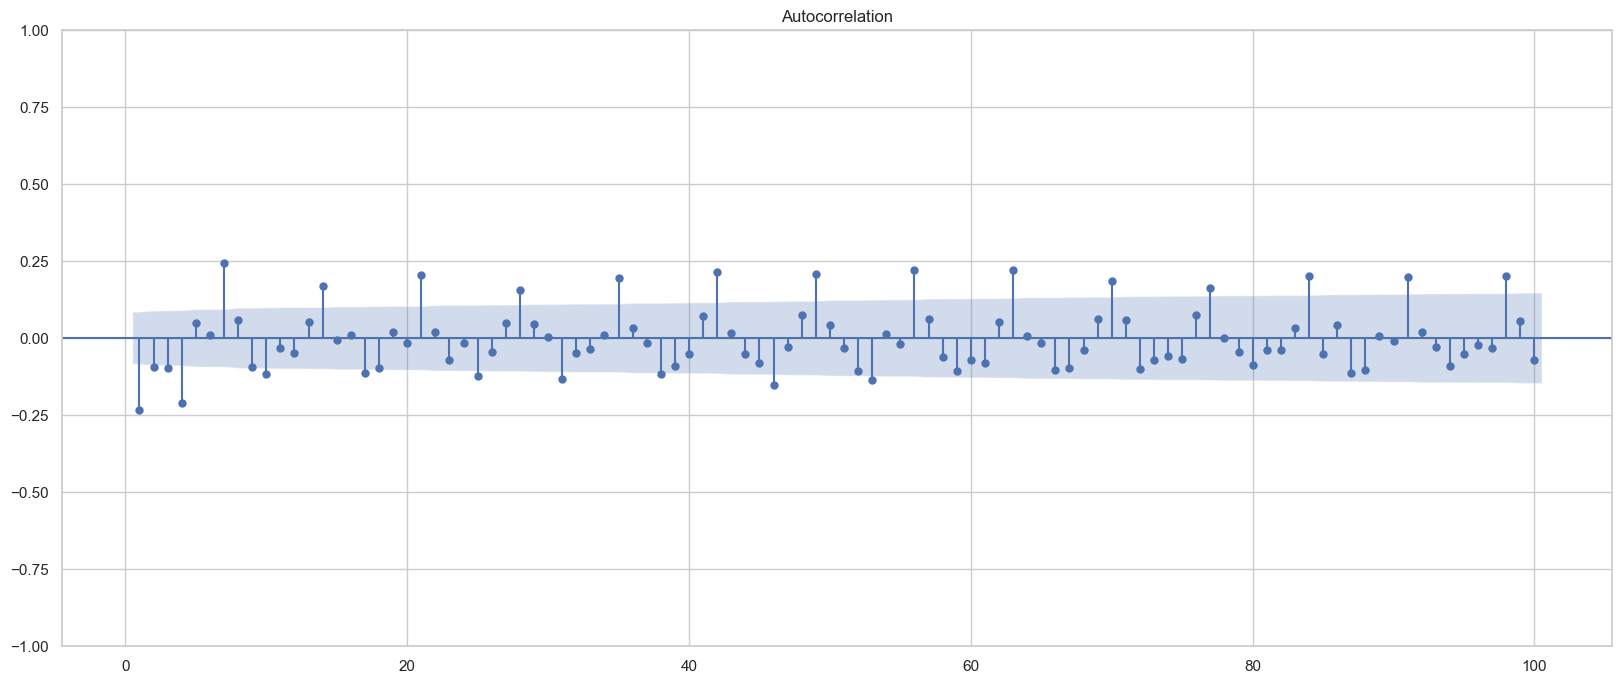

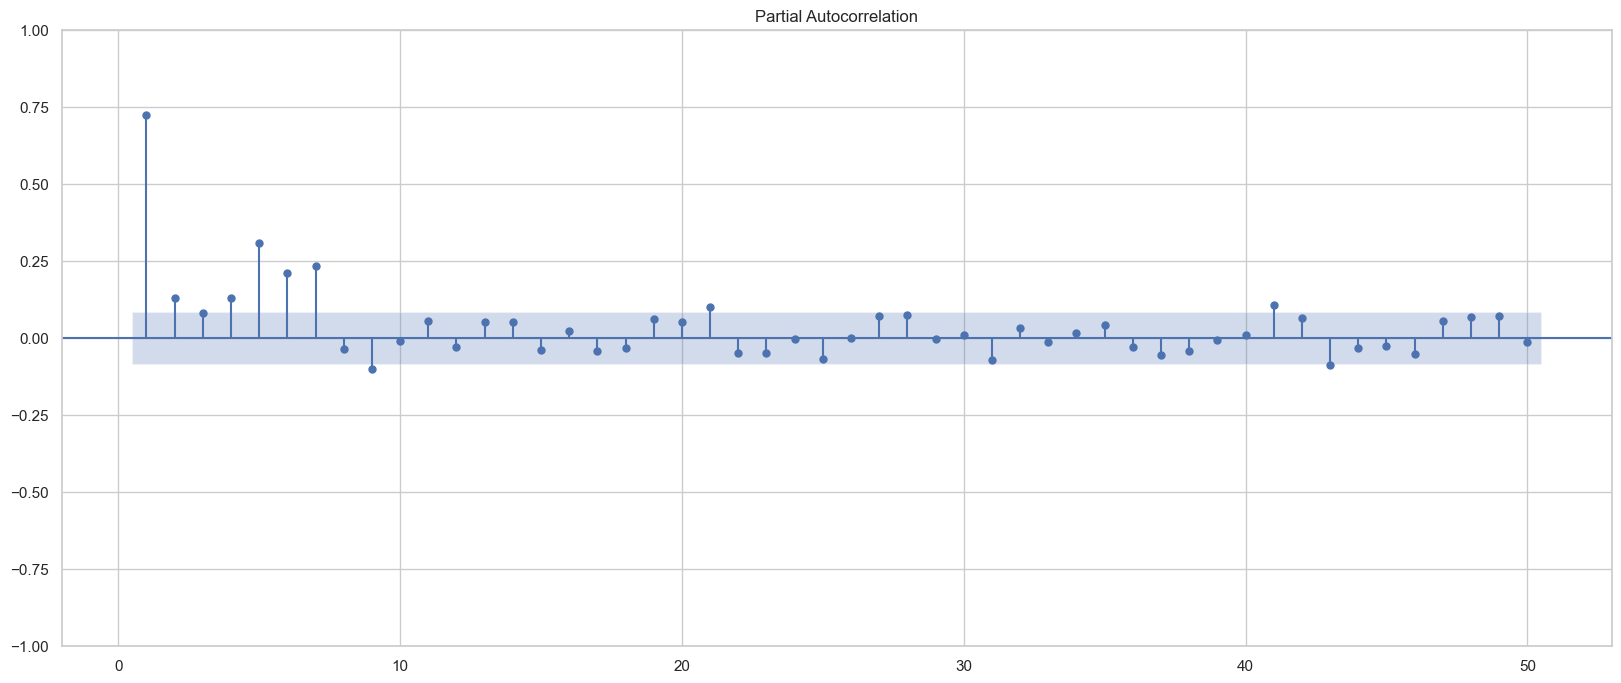

In [80]:
plot_acf(df_st["Japanese"], lags=100, zero=False);
plot_pacf(df["Japanese"], lags=50, zero=False);

In [6]:
params["Japanese"] = {
    "order": (7, 1, 7),
    "seasonal_order": (1, 1, 1, 12),
}


**French**


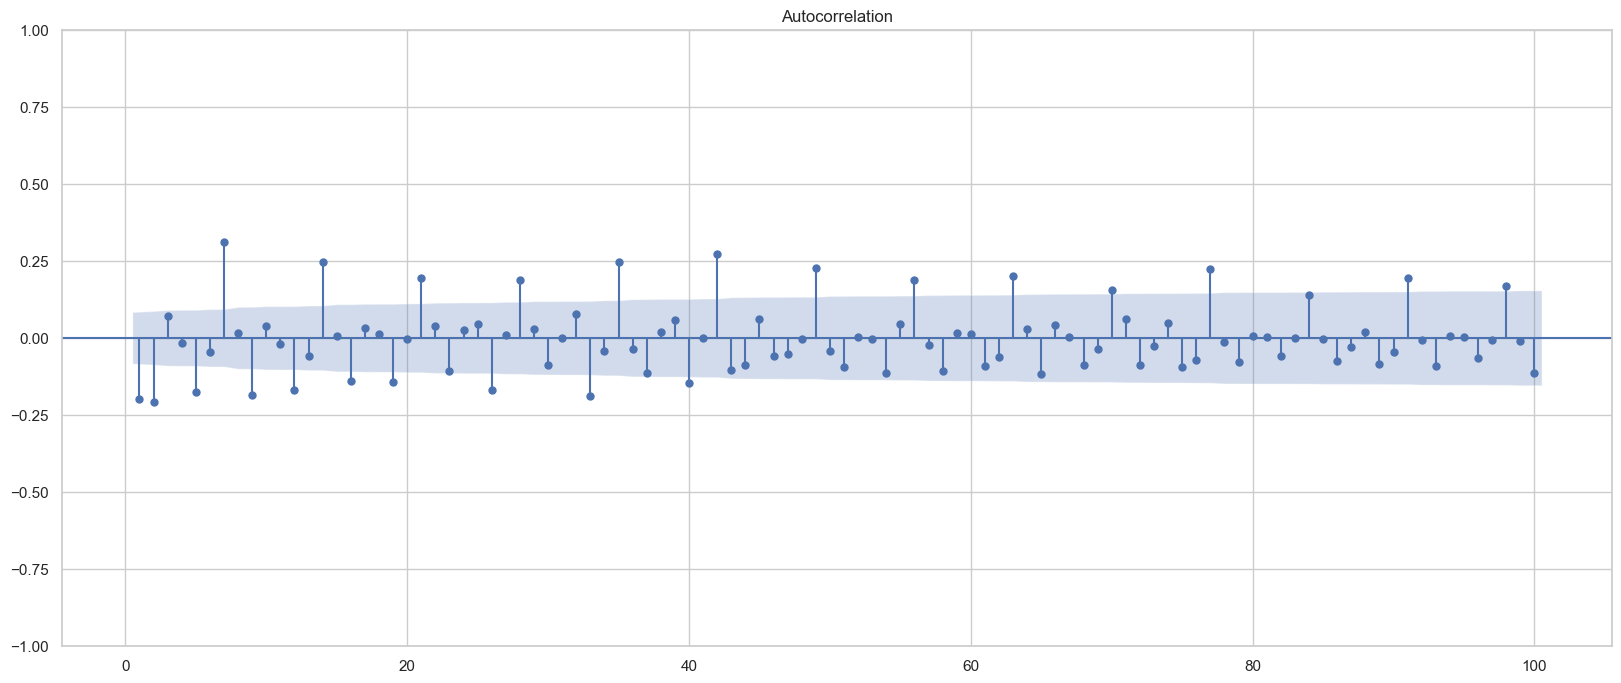

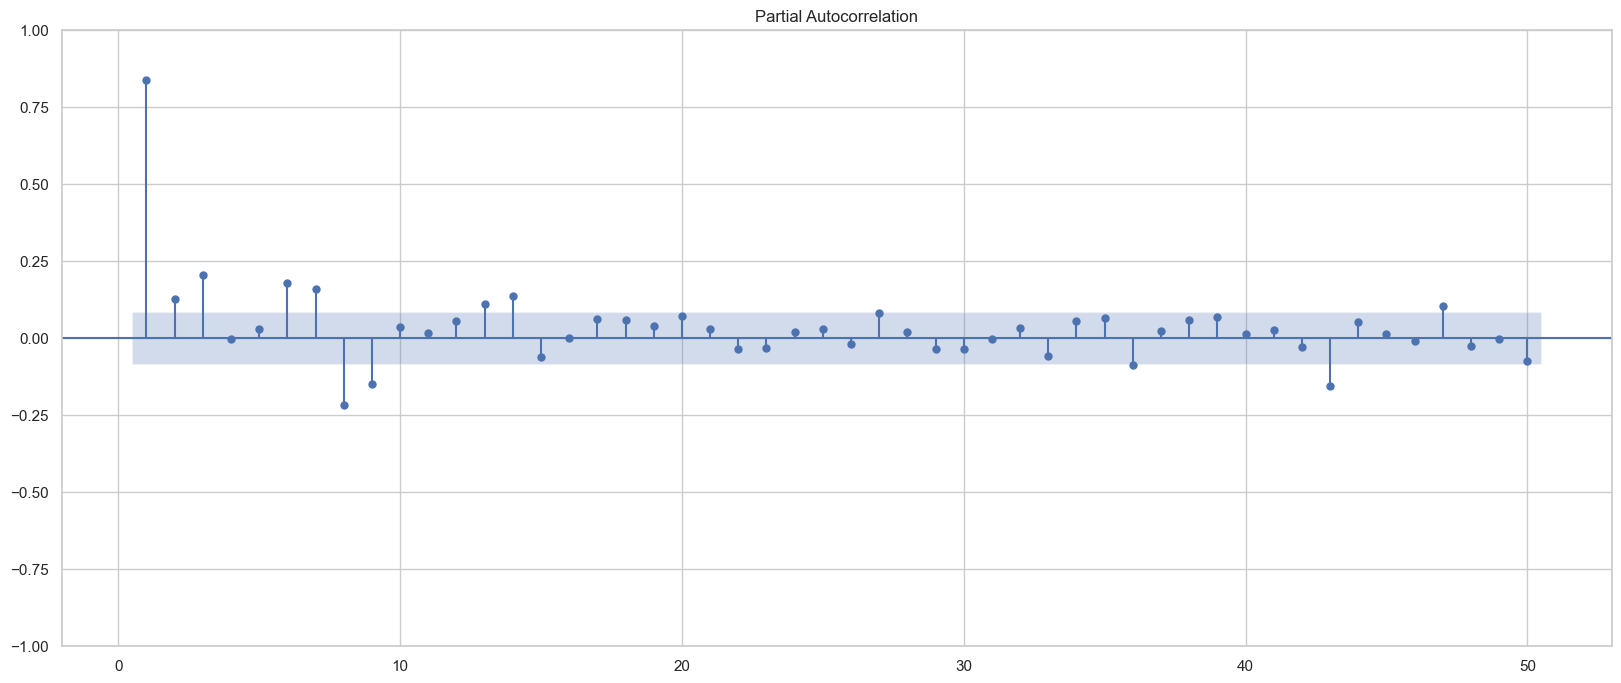

In [81]:
plot_acf(df_st["French"], lags=100, zero=False);
plot_pacf(df["French"], lags=50, zero=False);

In [7]:
params["French"] = {
    "order": (3, 1, 7),
    "seasonal_order": (1, 1, 1, 12),
}

**German**

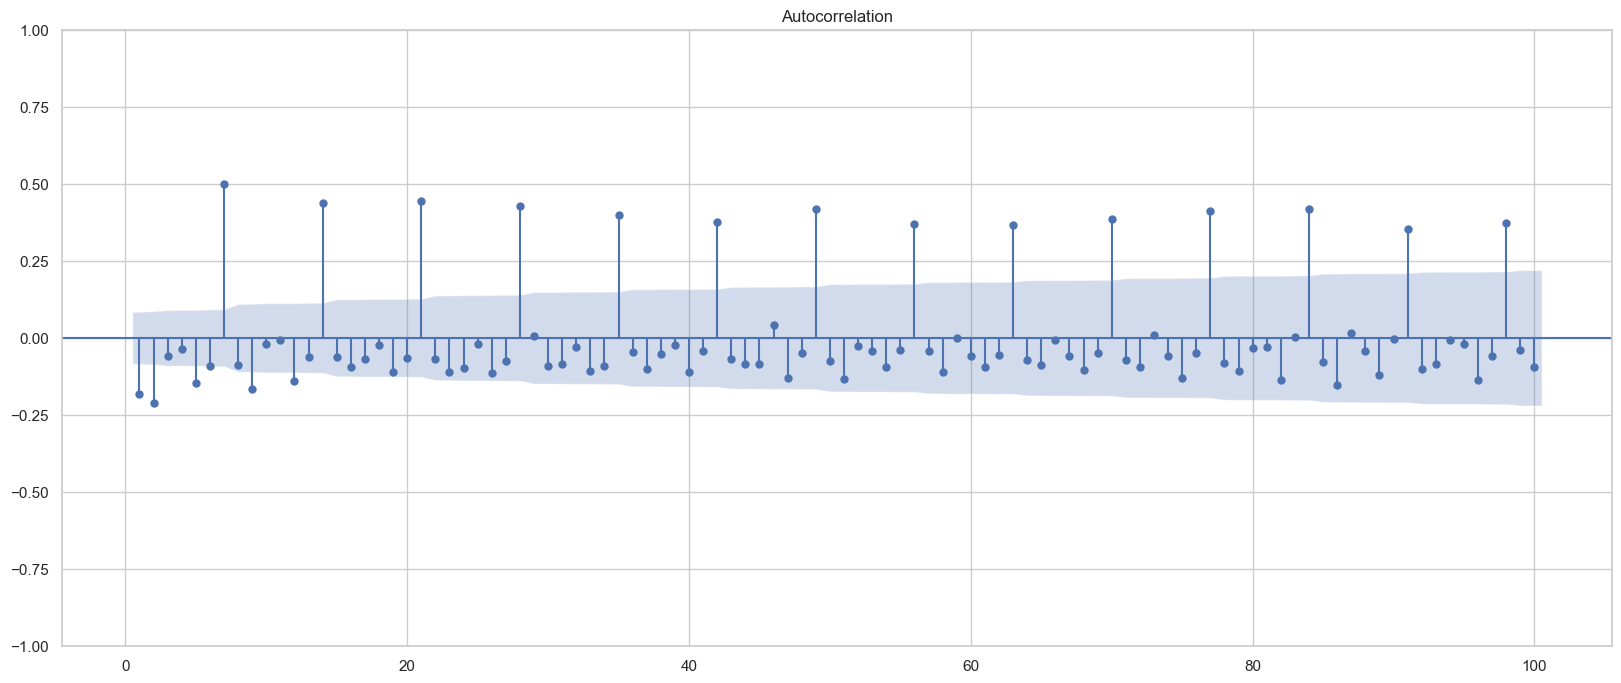

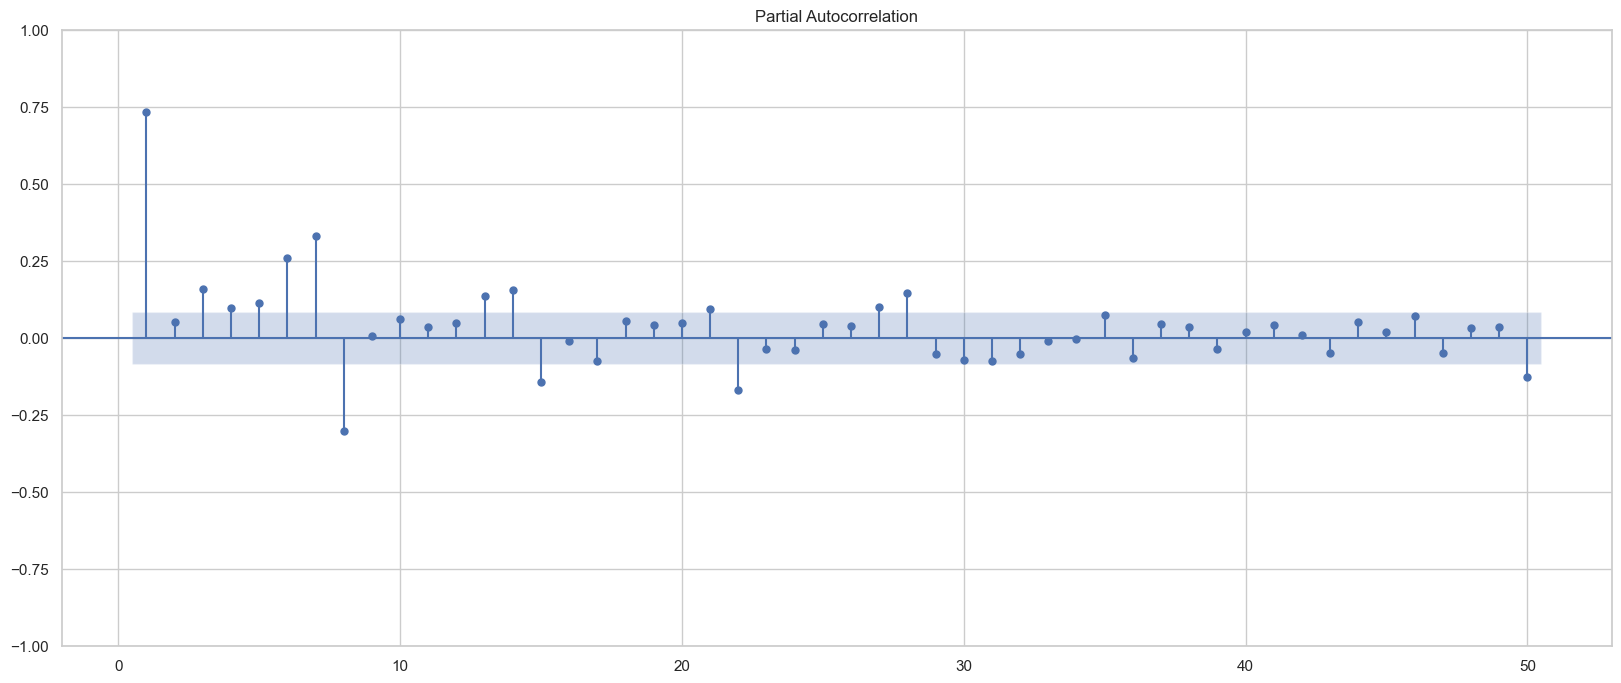

In [82]:
plot_acf(df_st["German"], lags=100, zero=False);
plot_pacf(df["German"], lags=50, zero=False);

In [8]:
params["German"] = {
    "order": (7, 1, 8),
    "seasonal_order": (1, 1, 1, 12),
}


**Chinese**


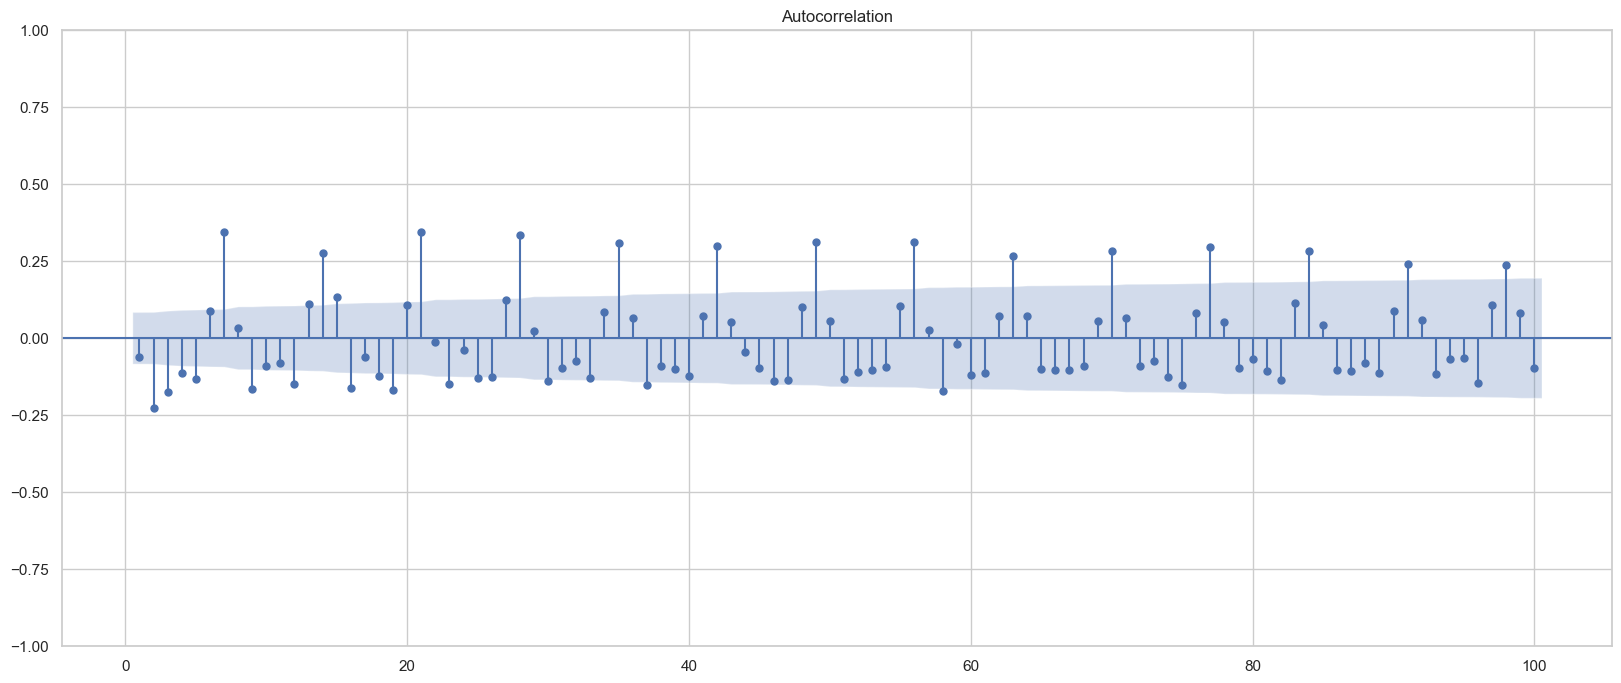

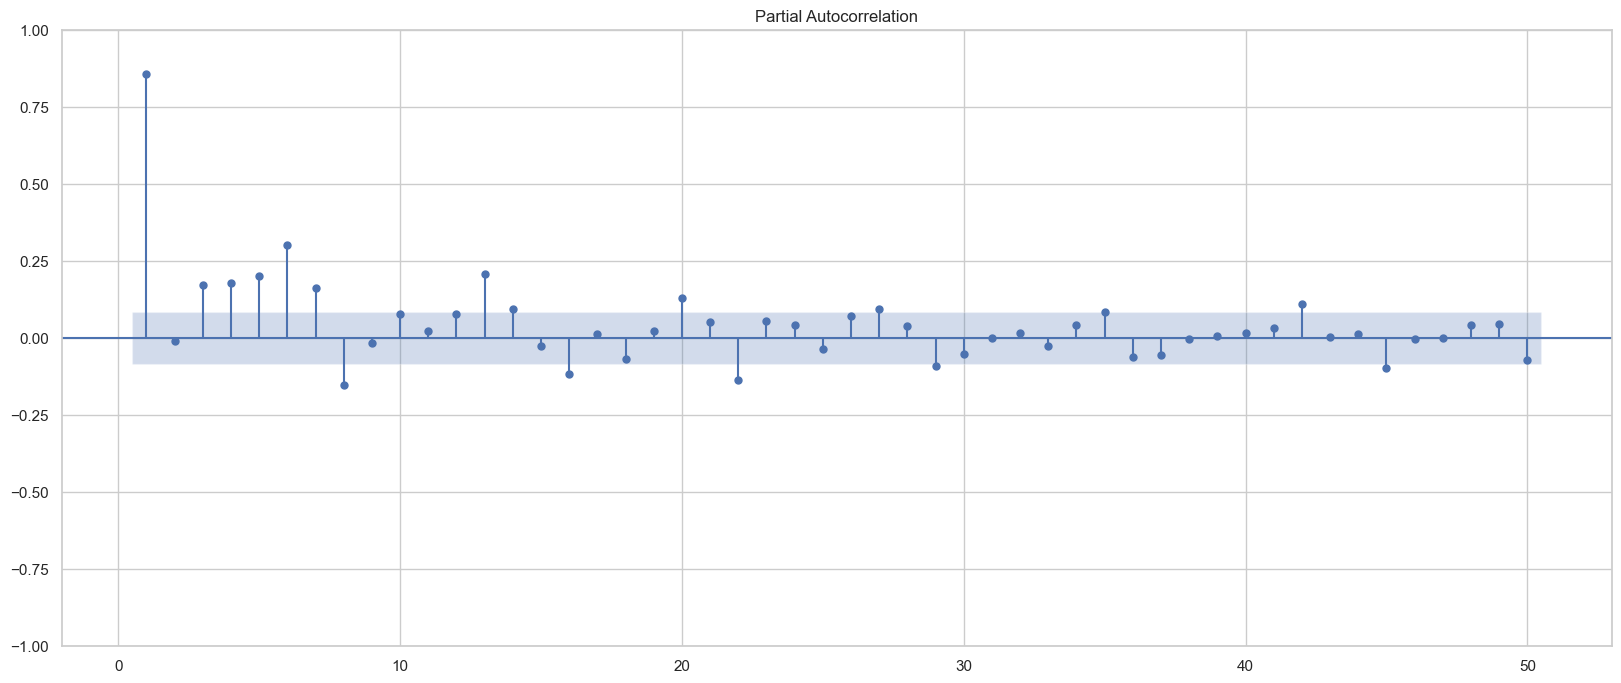

In [83]:
plot_acf(df_st["Chinese"], lags=100, zero=False);
plot_pacf(df["Chinese"], lags=50, zero=False);

In [9]:
params["Chinese"] = {
    "order": (7, 1, 8),
    "seasonal_order": (1, 1, 1, 12),
}

In [93]:
df_st.to_parquet("../data/processed/df_st.parquet")
df.to_parquet("../data/processed/df_pandas.parquet")

In [13]:
params
# import json
# with open("../data/processed/params.json", "w") as f:
#     json.dump(params, f)

{'English': {'order': (1, 1, 7), 'seasonal_order': (1, 1, 1, 12)},
 'Spanish': {'order': (6, 1, 7), 'seasonal_order': (1, 1, 1, 12)},
 'Russian': {'order': (3, 1, 2), 'seasonal_order': (1, 1, 1, 12)},
 'Japanese': {'order': (7, 1, 7), 'seasonal_order': (1, 1, 1, 12)},
 'French': {'order': (3, 1, 7), 'seasonal_order': (1, 1, 1, 12)},
 'German': {'order': (7, 1, 8), 'seasonal_order': (1, 1, 1, 12)},
 'Chinese': {'order': (7, 1, 8), 'seasonal_order': (1, 1, 1, 12)}}

# Model Building

In [14]:
df=pd.read_parquet("../data/processed/df_pandas.parquet")

In [18]:
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

In [19]:
# time based split
train = df.iloc[:int(0.8*len(df))]
test = df.iloc[int(0.8*len(df)):]

## ARIMA

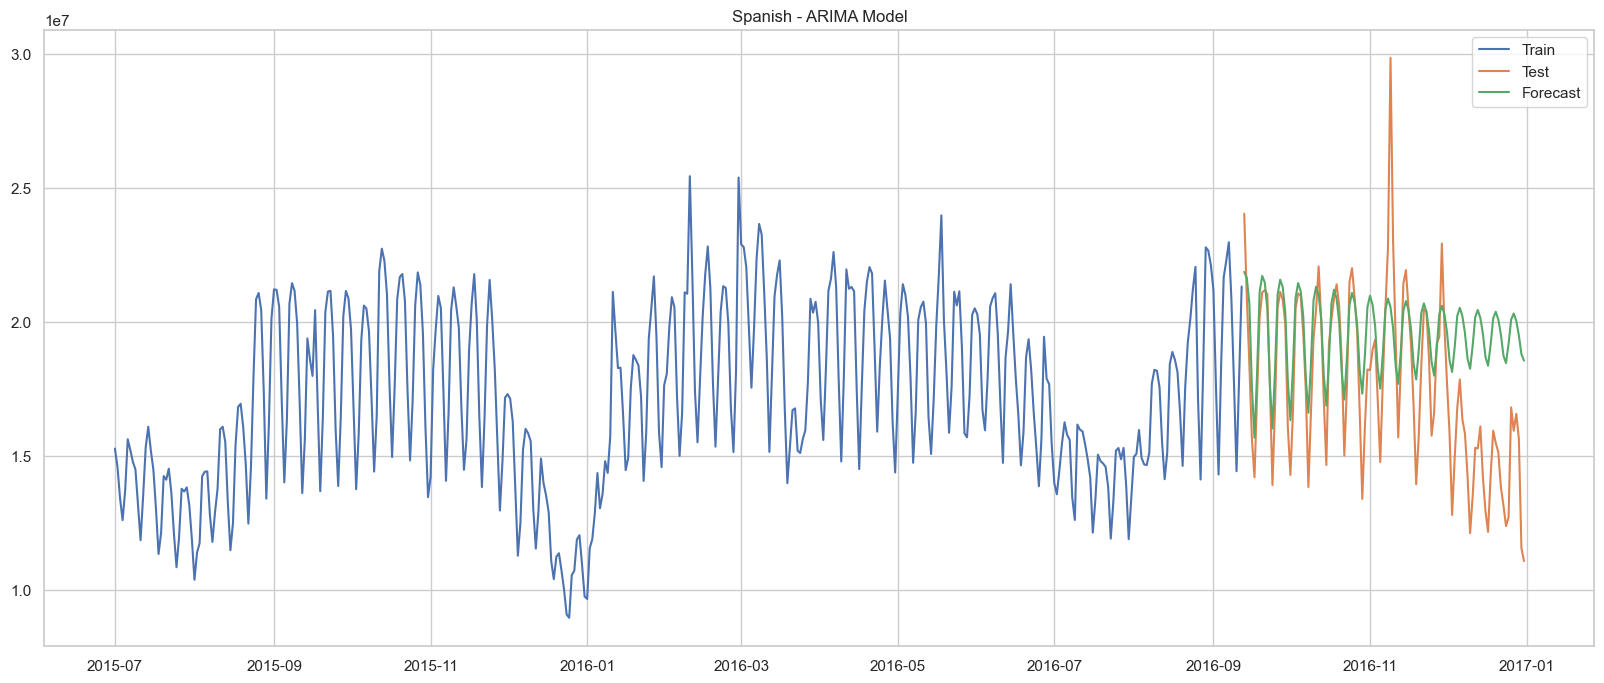

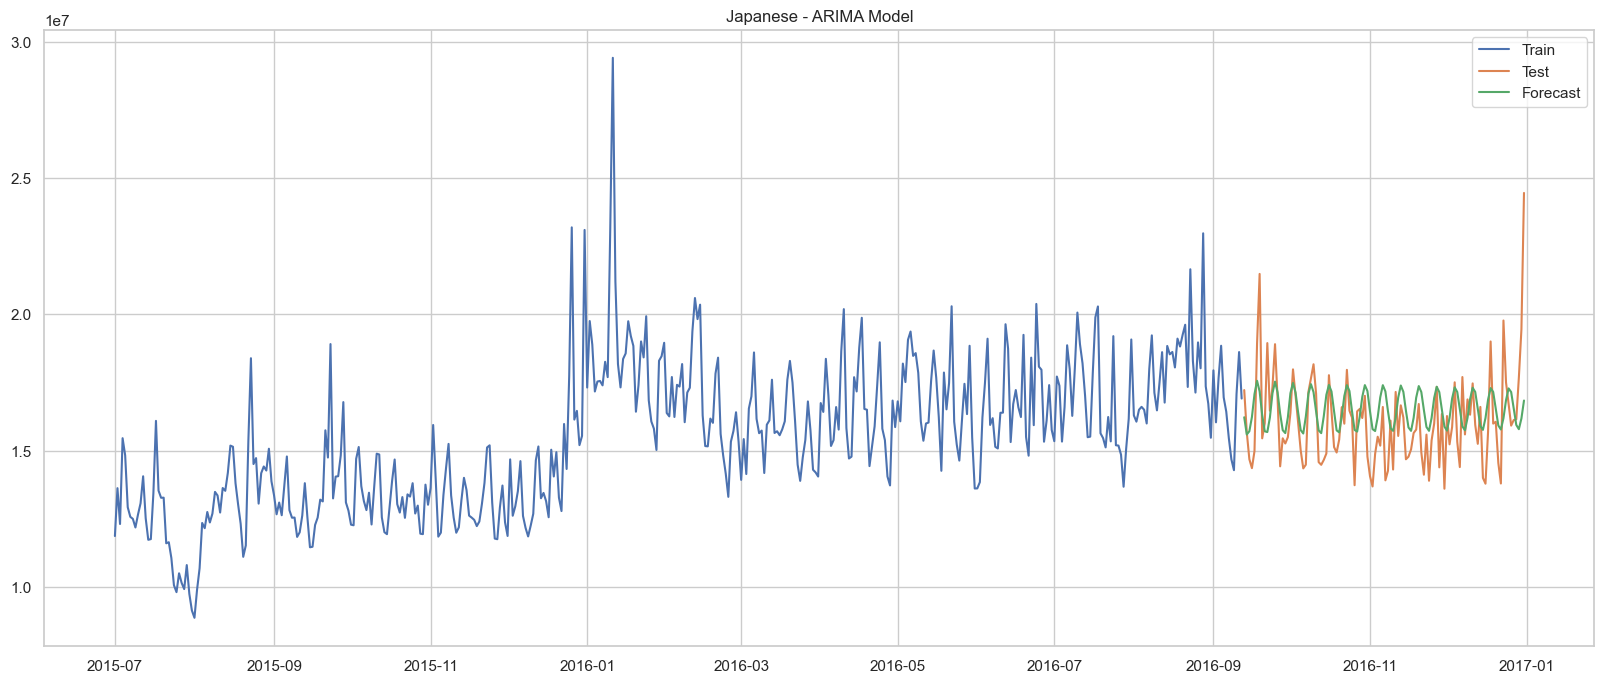

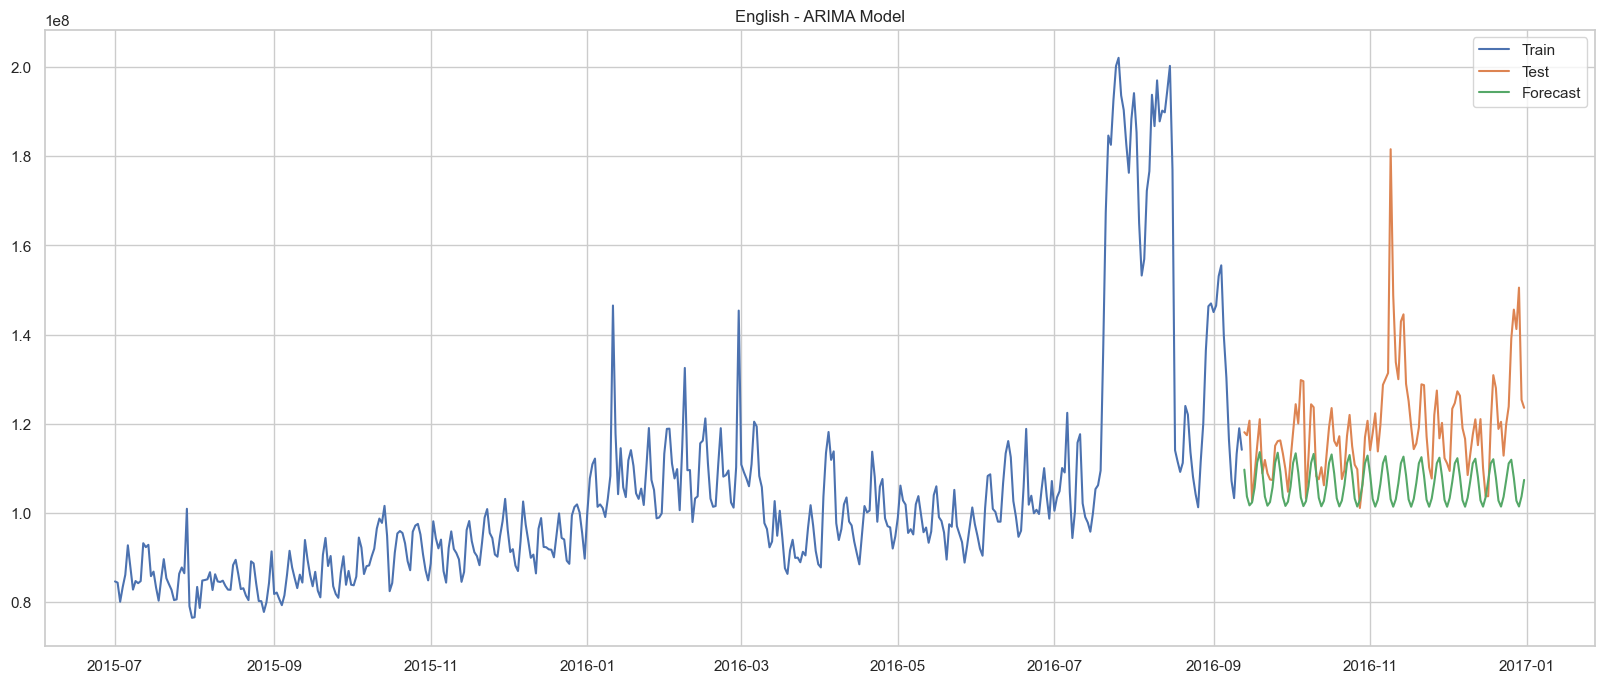

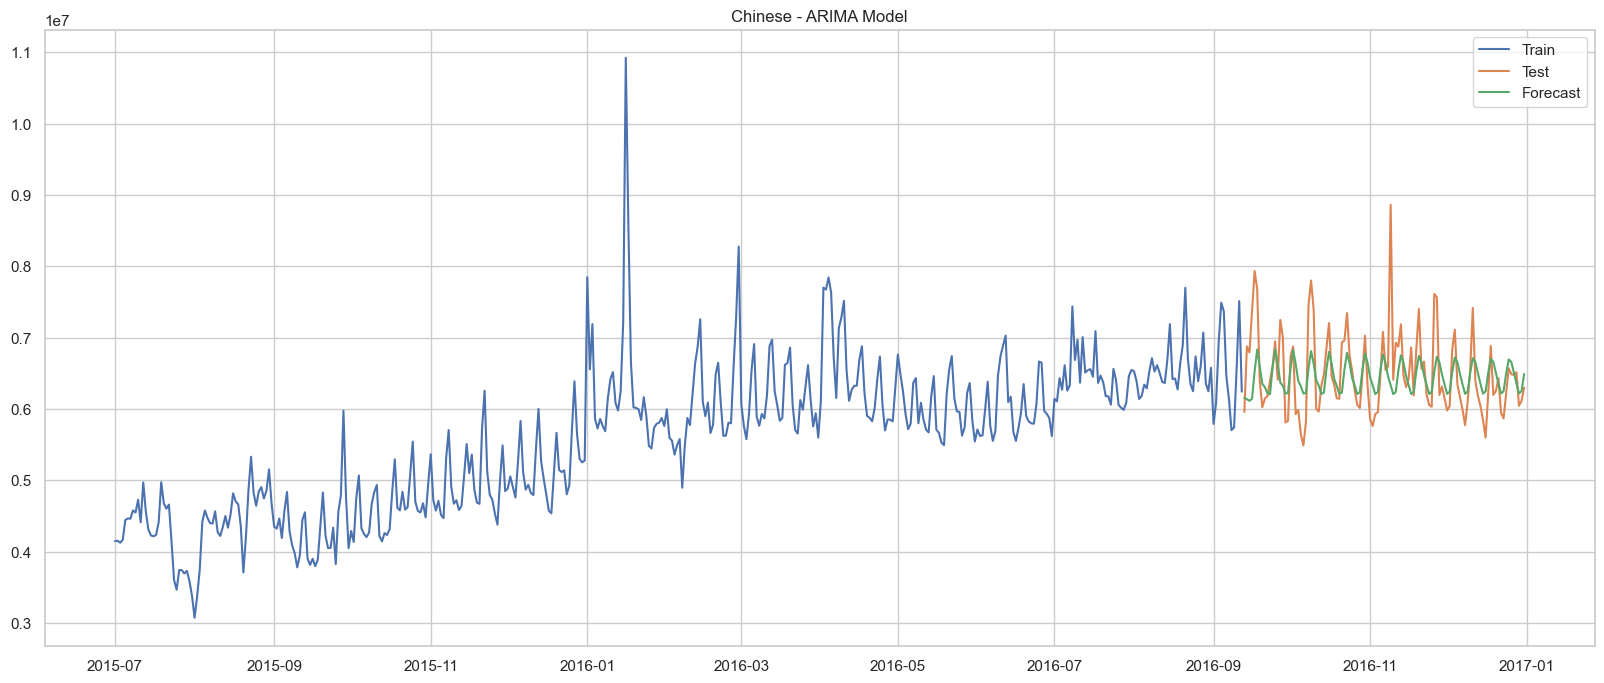

c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


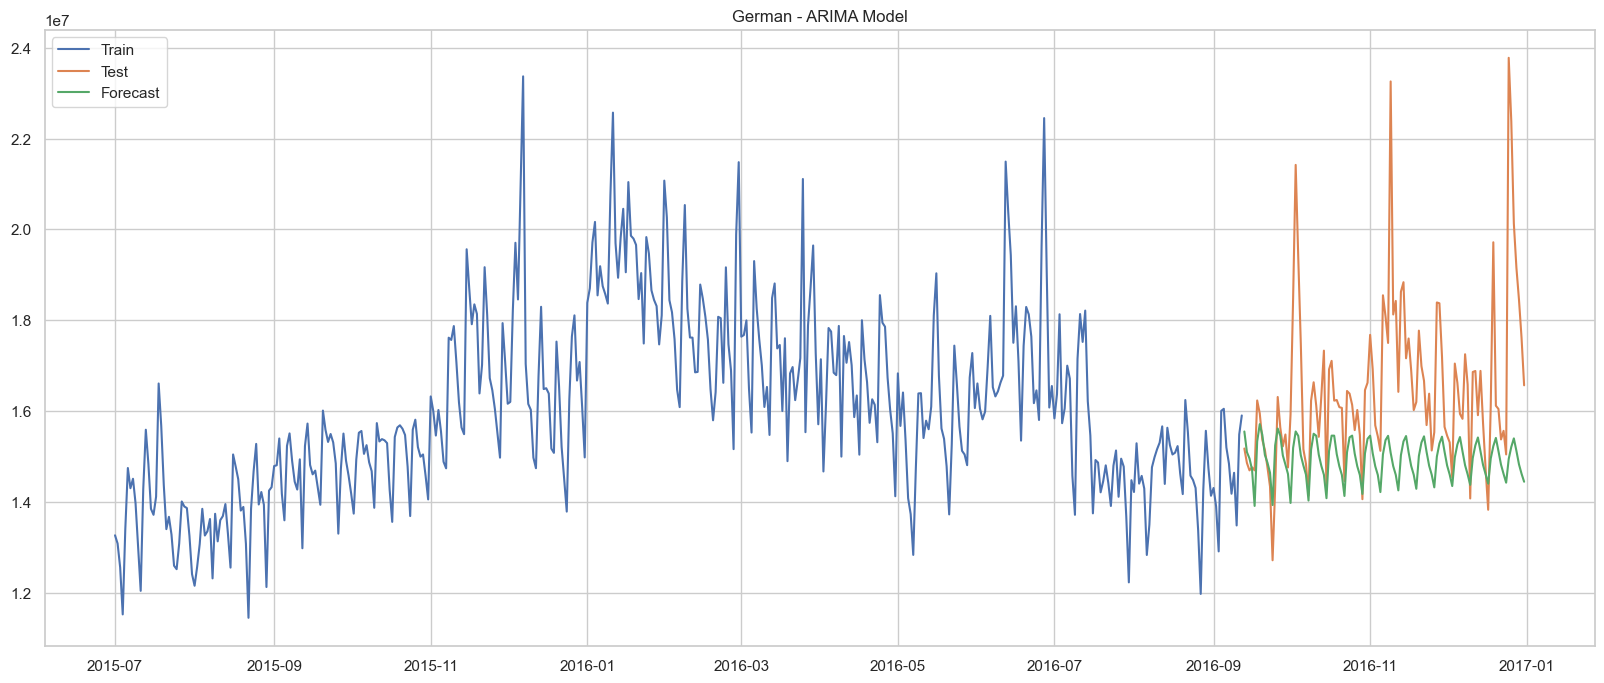

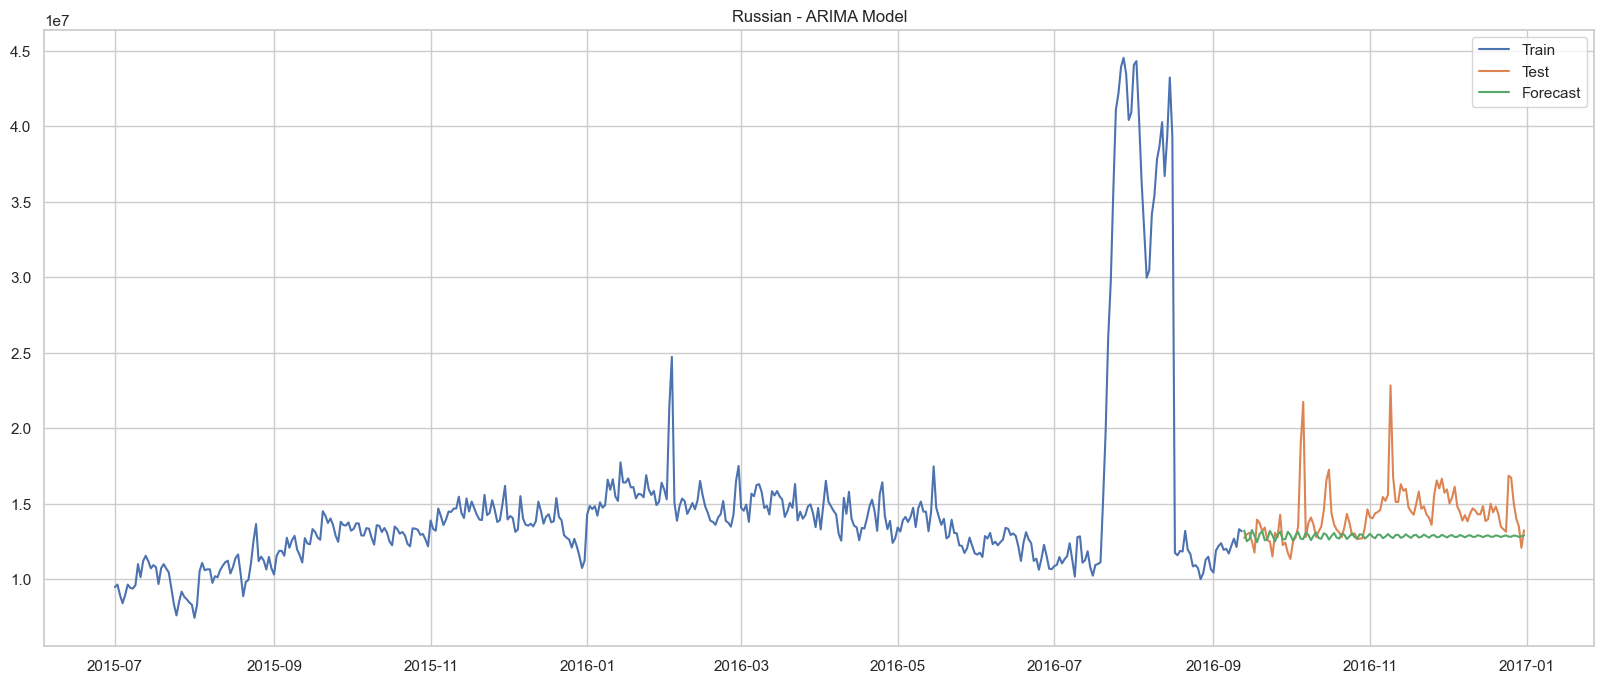

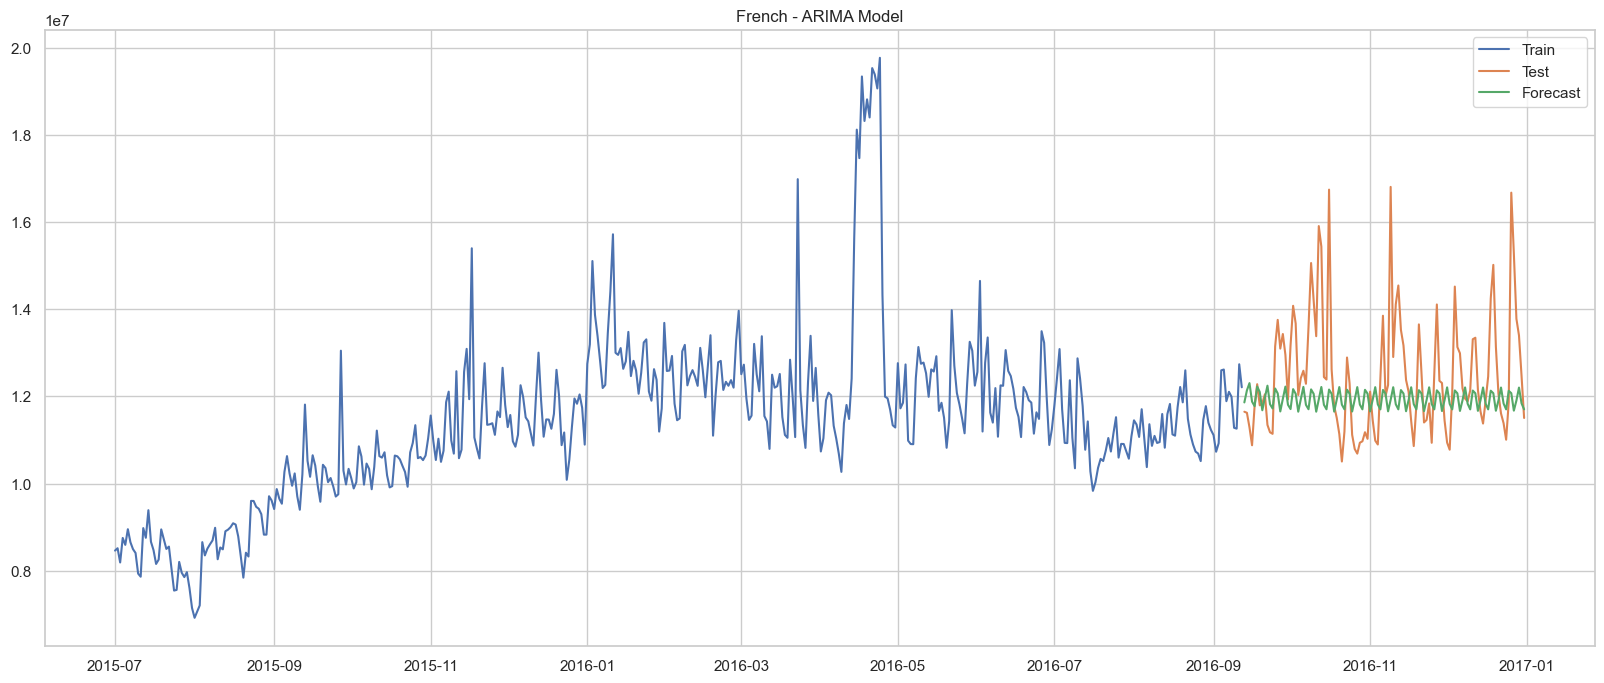

In [38]:
results = []
models={}

for column in columns:
    model = SARIMAX(train[column], order=params[column]["order"])
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    models[column] = model_fit
    
    results.append({
        "Language": column,
        'MAE': round(mae(test[column], forecast), 3),
        'RMSE': round(mse(test[column], forecast)**0.5, 3),
        'MAPE': round(mape(test[column], forecast), 3),
        'p': params[column]["order"][0],
        'd': params[column]["order"][1],
        'q': params[column]["order"][2],
    })
    
    # Plotting
    plt.figure(figsize=(20, 8))
    plt.plot(train[column], label="Train")
    plt.plot(test[column], label="Test")
    plt.plot(forecast, label="Forecast")
    plt.title(f"{column} - ARIMA Model")
    plt.legend()
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

In [39]:
results_df.sort_values("MAPE")

Language           MAE          RMSE   MAPE  p  d  q
3   Chinese  3.681971e+05  5.023556e+05  0.055  7  1  8
1  Japanese  1.202953e+06  1.599134e+06  0.075  7  1  7
6    French  1.060276e+06  1.452567e+06  0.080  3  1  7
4    German  1.629399e+06  2.286981e+06  0.091  7  1  8
2   English  1.297733e+07  1.719831e+07  0.102  9  1  6
5   Russian  1.657838e+06  2.290341e+06  0.107  3  1  2
0   Spanish  2.302304e+06  3.066079e+06  0.150  6  1  7

## SARIMAX

In [56]:
params["English"] = { "order": (6, 1, 6), "seasonal_order": (1, 0, 1, 7) }
model = SARIMAX(train["English"], order=params["English"]["order"], exog=train["Exog"], seasonal_order= params["English"]["seasonal_order"] )
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test), exog=test["Exog"])
performance(test["English"], forecast)


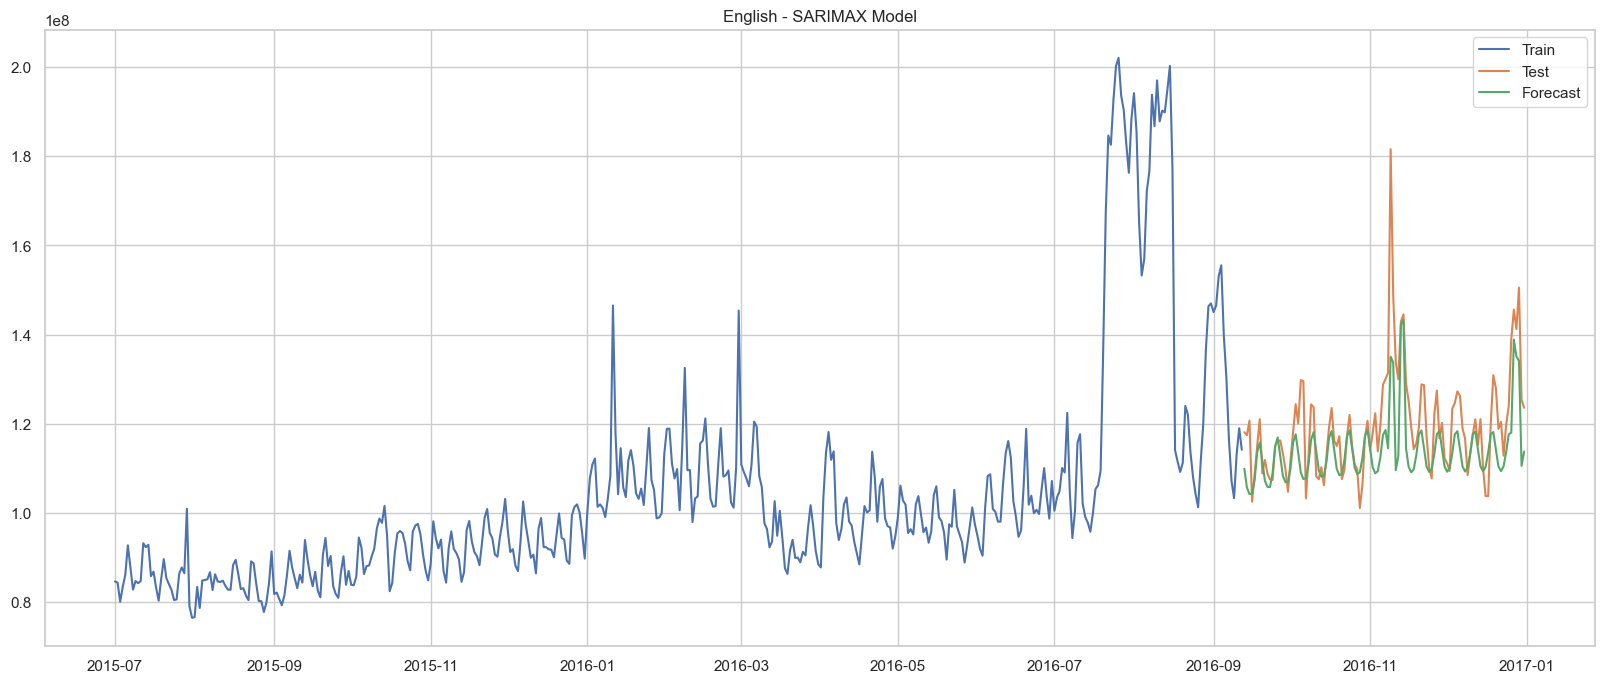

In [70]:

# Plotting
plt.figure(figsize=(20, 8))
plt.plot(train["English"], label="Train")
plt.plot(test["English"], label="Test")
plt.plot(forecast, label="Forecast")
# plt.xlim(test.index.min()-timedelta(days=50), test.index.max())
plt.title("English - SARIMAX Model")
plt.legend()
plt.show()

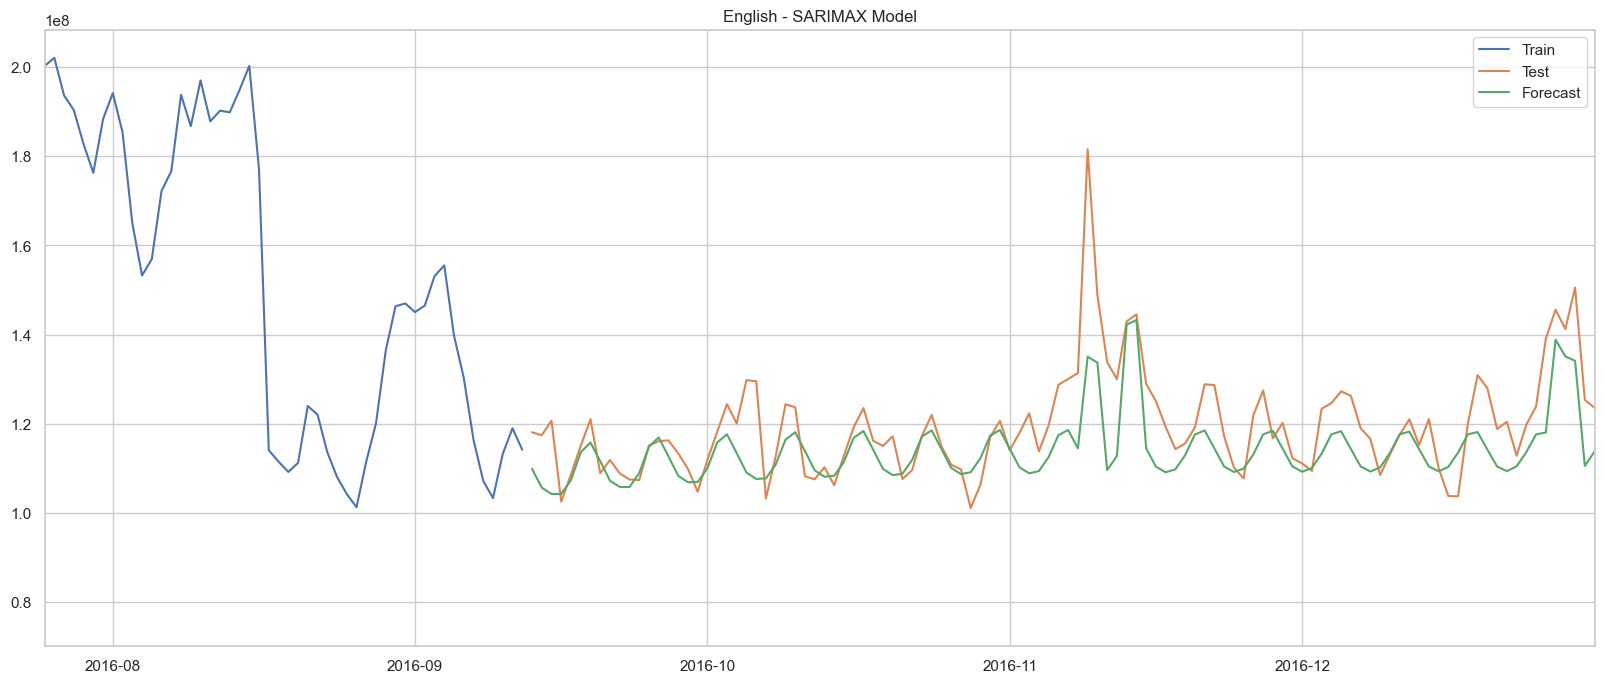

In [71]:
# Plotting
plt.figure(figsize=(20, 8))
plt.plot(train["English"], label="Train")
plt.plot(test["English"], label="Test")
plt.plot(forecast, label="Forecast")
plt.xlim(test.index.min()-timedelta(days=50), test.index.max())
plt.title("English - SARIMAX Model")
plt.legend()
plt.show()

## Hyperparameter Tuning using Optuna

In [76]:
def performance(true_values, predictions):
    return mape(true_values, predictions)


def objective(trial):

    p = trial.suggest_int('p', 0, 7)  # AR term
    # d = trial.suggest_int('d', 0, 2)  # Differencing term
    q = trial.suggest_int('q', 0, 7)  # MA term
    P = trial.suggest_int('P', 0, 2)  # Seasonal AR term
    D = trial.suggest_int('D', 0, 1)  # Seasonal differencing
    Q = trial.suggest_int('Q', 0, 2)  # Seasonal MA term
    S = 7 # Seasonal period (weekly seasonality)

    order = (p, 1, q)
    seasonal_order = (P, D, Q, S)
    
    try:
        model = SARIMAX(train["English"], order=order, exog=train["Exog"], seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False) 
        forecast = model_fit.forecast(steps=len(test), exog=test["Exog"])
        
        error = performance(test["English"], forecast)
    except Exception as e:
        error = np.inf

    return error

storage_name = "sqlite:///sarimax_optuna_study.db"

study = optuna.create_study(direction='minimize', study_name="sarimax_study", storage=storage_name, load_if_exists=True)

study.optimize(objective, n_trials=100)

In [75]:
print("Best hyperparameters: ", study.best_trial.params)
print("Best MAPE: ", study.best_value)

Best hyperparameters:  {'p': 3, 'q': 5, 'P': 0, 'D': 1, 'Q': 1}
Best MAPE:  0.04394953148191757


In [77]:
params["English"] = { "order": (3, 1, 5), "seasonal_order": (0, 1, 1, 7) }
model = SARIMAX(train["English"], order=params["English"]["order"], exog=train["Exog"], seasonal_order= params["English"]["seasonal_order"] )
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test), exog=test["Exog"])
performance(test["English"], forecast)

0.04394953148191757

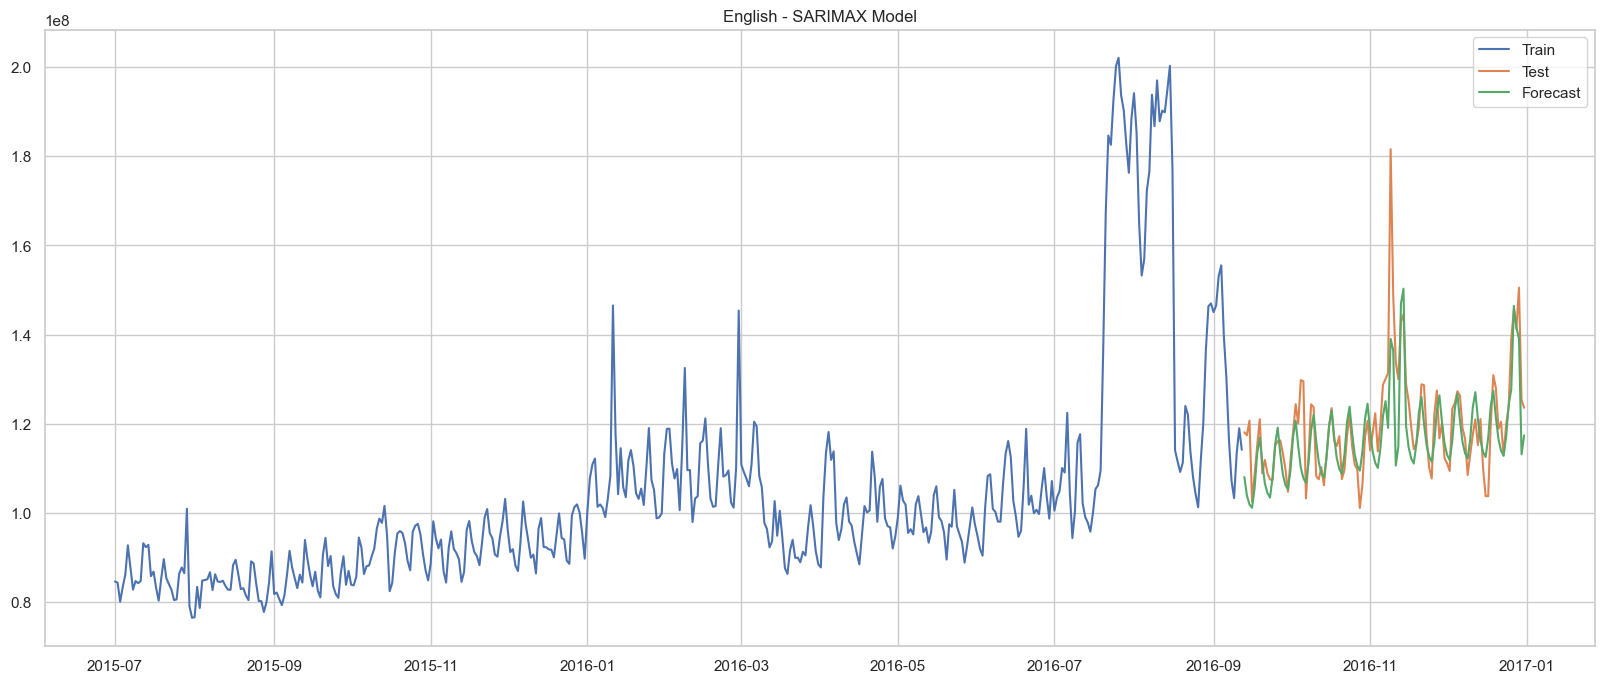

In [78]:
plt.figure(figsize=(20, 8))
plt.plot(train["English"], label="Train")
plt.plot(test["English"], label="Test")
plt.plot(forecast, label="Forecast")
# plt.xlim(test.index.min()-timedelta(days=50), test.index.max())
plt.title("English - SARIMAX Model")
plt.legend()
plt.show()

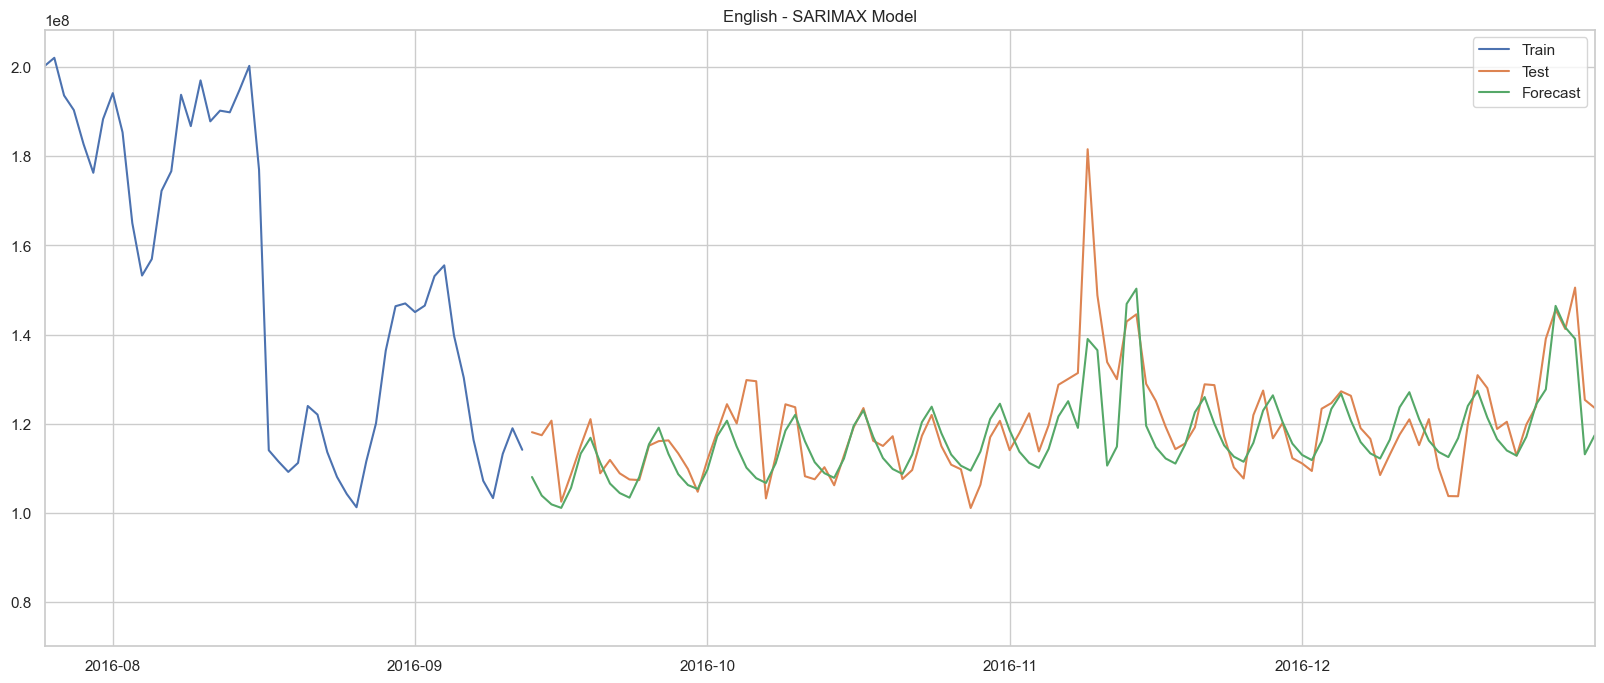

In [79]:
# Plotting
plt.figure(figsize=(20, 8))
plt.plot(train["English"], label="Train")
plt.plot(test["English"], label="Test")
plt.plot(forecast, label="Forecast")
plt.xlim(test.index.min()-timedelta(days=50), test.index.max())
plt.title("English - SARIMAX Model")
plt.legend()
plt.show()

## Prophet Model

In [130]:
fb_df_english = pd.DataFrame({
    "ds": df.index,
    "y": df["English"],
    "regressor": df["Exog"]
}).reset_index(drop=True)

fb_df_english

ds          y  regressor
0   2015-07-01   84712323          0
1   2015-07-02   84438676          0
2   2015-07-03   80167807          0
3   2015-07-04   83463351          0
4   2015-07-05   86198774          0
..         ...        ...        ...
545 2016-12-27  145628953          1
546 2016-12-28  141278597          1
547 2016-12-29  150557723          1
548 2016-12-30  125404796          0
549 2016-12-31  123624015          0

[550 rows x 3 columns]

In [145]:
train = fb_df_english.iloc[:int(0.8*len(fb_df_english))]
test = fb_df_english.iloc[int(0.8*len(fb_df_english)):]

In [146]:
m = Prophet( weekly_seasonality=True)
m.add_regressor('regressor')
m.fit(train)

02:44:08 - cmdstanpy - INFO - Chain [1] start processing
02:44:08 - cmdstanpy - INFO - Chain [1] done processing


In [147]:
future = m.make_future_dataframe(periods=len(test))
future["regressor"] = fb_df_english["regressor"]

In [148]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','regressor']].tail()

ds          yhat    yhat_lower    yhat_upper     regressor
545 2016-12-27  1.702280e+08  1.561829e+08  1.843275e+08  5.638329e+07
546 2016-12-28  1.703214e+08  1.551213e+08  1.846318e+08  5.638329e+07
547 2016-12-29  1.671508e+08  1.515208e+08  1.830582e+08  5.638329e+07
548 2016-12-30  1.139182e+08  9.930492e+07  1.282830e+08  0.000000e+00
549 2016-12-31  1.140126e+08  9.860539e+07  1.289302e+08  0.000000e+00

In [149]:
forecast = forecast.set_index("ds")
train = train.set_index("ds")
test = test.set_index("ds")

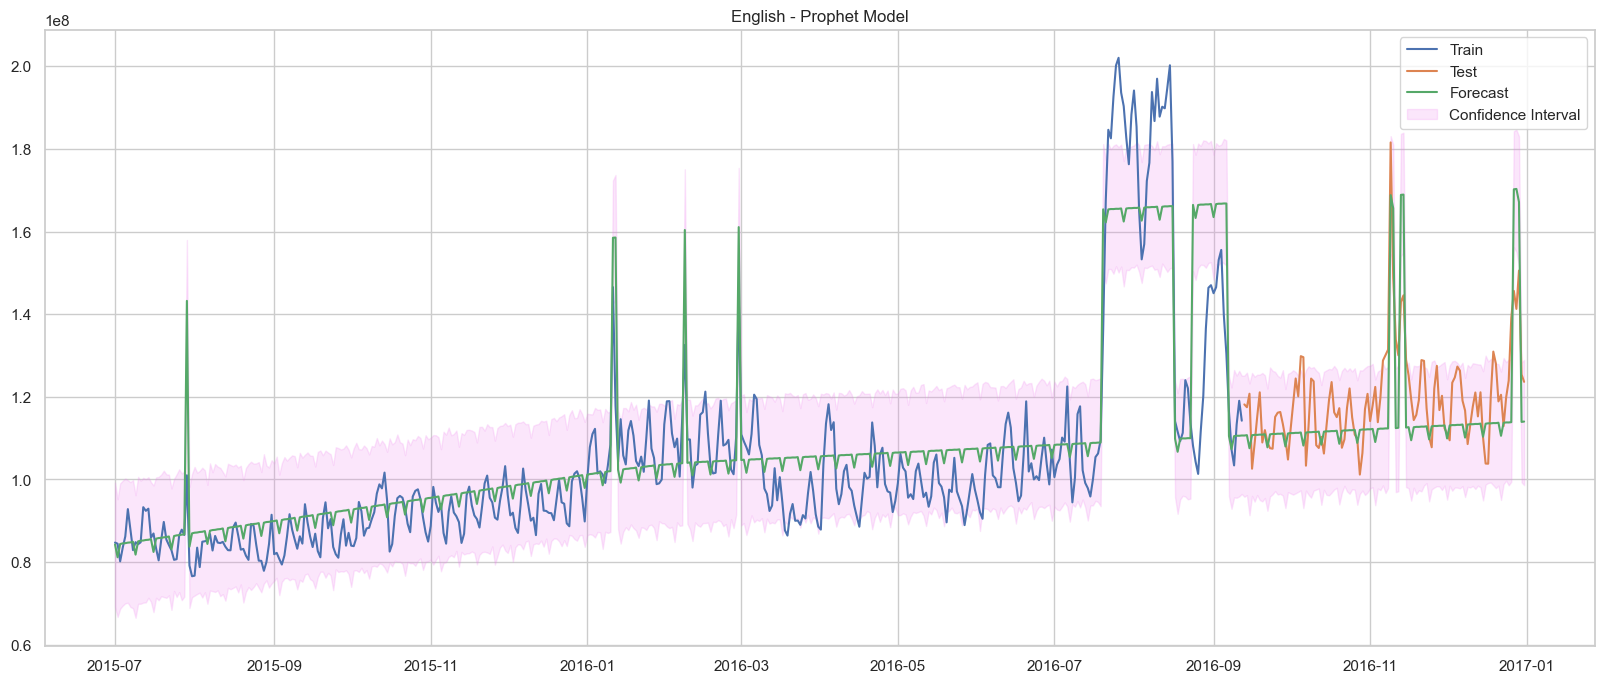

In [150]:
plt.figure(figsize=(20, 8))
plt.plot(train["y"], label="Train")
plt.plot(test["y"], label="Test")
plt.plot(forecast["yhat"], label="Forecast")
plt.fill_between(forecast.index, forecast["yhat_lower"], forecast["yhat_upper"], color='violet', alpha=0.2, label="Confidence Interval")
plt.title("English - Prophet Model")
plt.legend()
plt.show()

In [137]:
performance(test["y"], forecast.loc[test.index, "yhat"])

0.06757235892244666